# Details of Walmart project:

You are provided with the weekly sales data for their various outlets. Use statistical analysis, EDA, outlier analysis, and handle the missing values to come up with various insights that can give them a clear perspective on the following:

a. If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

b. If the weekly sales show a seasonal trend, when and what could be the reason?

c. Does temperature affect the weekly sales in any manner?

d. How is the Consumer Price index affecting the weekly sales of various stores?

e. Top performing stores according to the historical data.

f.The worst performing store, and how significant is the difference between the highest and lowest performing stores.

g. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks

In [2]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
# Import the walmart dataset

df = pd.read_csv("Walmart DataSet.csv")
df.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

# Explore the datatypes, outliers, missing and duplicated values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
# data type of Date column is object. Should be changed into Date format. Convert temperature from fahrenhite to celsius.

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Temperature'] = (df['Temperature'] - 32) * 5/9

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [8]:
df.describe()

Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    15.924324     3.358607   
std      12.988182  5.643666e+05      0.255049    10.247185     0.459020   
min       1.000000  2.099862e+05      0.000000   -18.922222     2.472000   
25%      12.000000  5.533501e+05      0.000000     8.588889     2.933000   
50%      23.000000  9.607460e+05      0.000000    17.038889     3.445000   
75%      34.000000  1.420159e+06      0.000000    23.855556     3.735000   
max      45.000000  3.818686e+06      1.000000    37.855556     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000      3.879000  
25%     131.735000      6.891000  
50%     182.616521      7.874000  
75%     212.743293      8.622000  
max     227.232807     14.313000

Note: Lot of difference in minimum and maximum sales values. Standard deviation is also high.

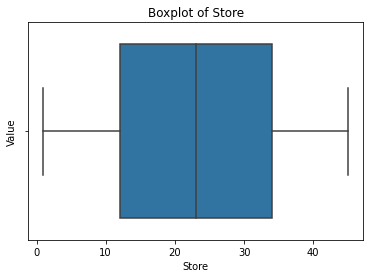

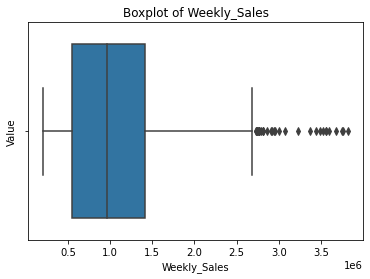

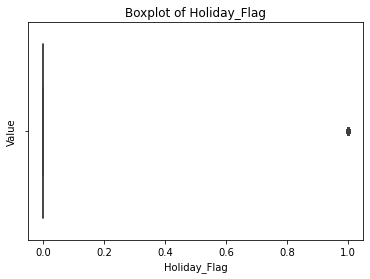

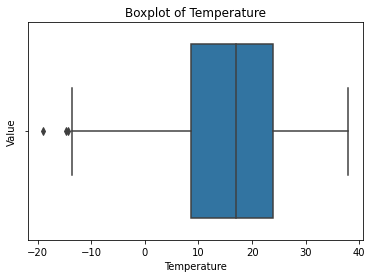

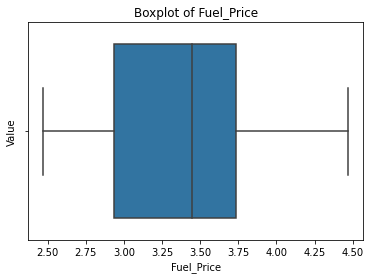

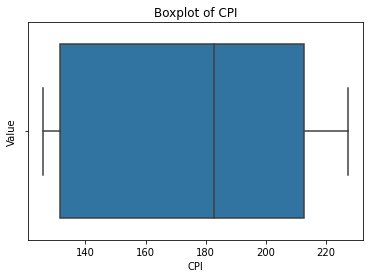

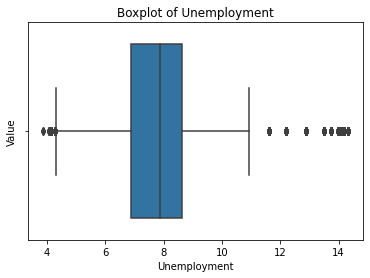

In [9]:
# Outliers detection by box plot

numeric_cols = ['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment']

for col in numeric_cols:
    sns.boxplot(x=col, data=df)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Value')
    plt.show()

As per the boxplot, there are outliers in weekly sales and unemployment rate column. However, we should look for seasonal pattern to understand the impact of outliers.

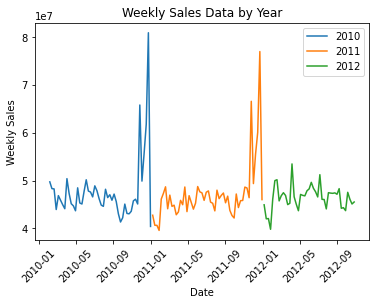

In [10]:

df['Year'] = df['Date'].dt.year

# Group data by year and date, then calculate weekly sales sum
yearly_sales = df.groupby([df['Year'], df['Date'].dt.date])['Weekly_Sales'].sum().reset_index()

# Create a separate plot for each year
fig, ax = plt.subplots()

for year in yearly_sales['Year'].unique():
    year_data = yearly_sales[yearly_sales['Year'] == year]
    ax.plot(year_data['Date'], year_data['Weekly_Sales'], label=str(year))

# Set plot title and axis labels
ax.set_title('Weekly Sales Data by Year')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


Note: There is a seasonal increase in the weekly sales during the months of november and december. This could be due to thanksgiving, christmas and new year holidays. Therefore, outliers should be because of the seasonal rise of weekly sales. Thus, outliers should not be removed. We will see fo further analysis if we want to standardize the data on same scale.

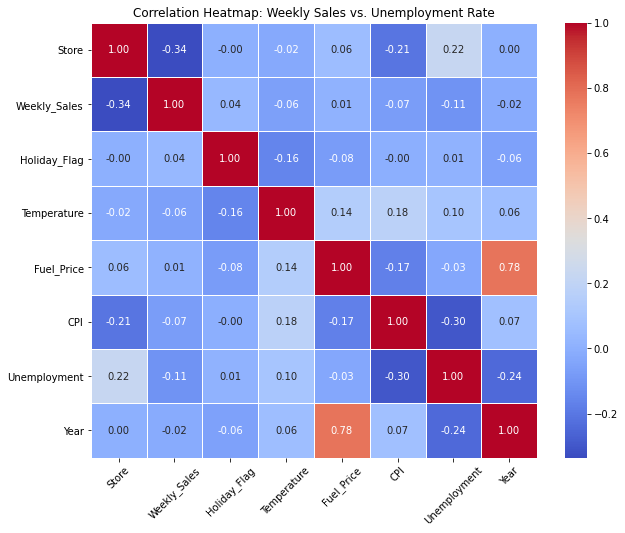

In [11]:
# If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?
#Does temperature affect the weekly sales in any manner?
# How is the Consumer Price index affecting the weekly sales of various stores?

#Correlation between variables using heat map

df.set_index('Date', inplace = True)

corr = df.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Weekly Sales vs. Unemployment Rate')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Note: There is a weak correlation between the variables. Unemployment rate, temperature, and CPI are negatively correlated with Weekly_Sales but the correlation is very low. This indicated that change in one variable do not result in significant proportional change alterations in the other. Fuel price has a resonably good positive correlation with the year.

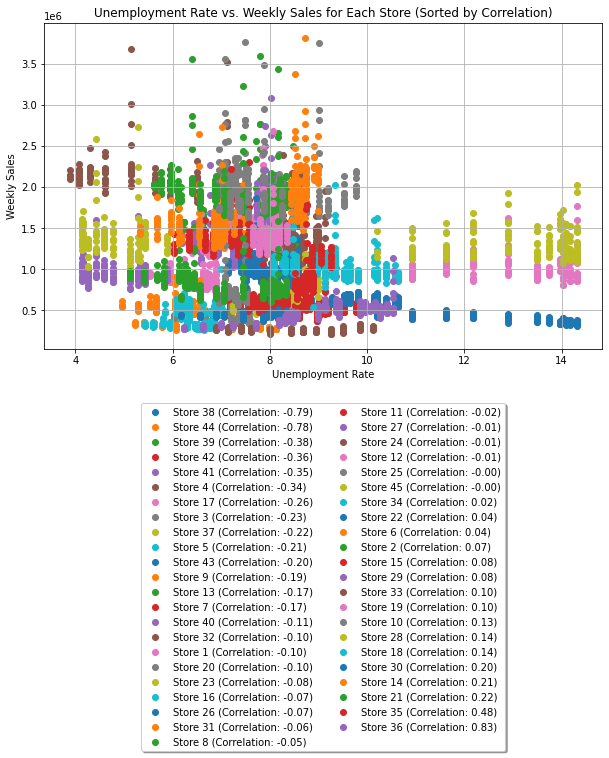

In [12]:
# store-wise correlation between unemployment rate and weekly sales

correlation_by_store = df.groupby('Store').apply(lambda x: x['Unemployment'].corr(x['Weekly_Sales']))

# Sort stores based on correlation value in descending order
sorted_stores = correlation_by_store.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
for store_id, corr in sorted_stores.items():
    store_data = df[df['Store'] == store_id]
    plt.scatter(store_data['Unemployment'], store_data['Weekly_Sales'], label=f'Store {store_id} (Correlation: {corr:.2f})')

plt.xlabel('Unemployment Rate')
plt.ylabel('Weekly Sales')
plt.title('Unemployment Rate vs. Weekly Sales for Each Store (Sorted by Correlation)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.grid(True)
plt.show()

Note: Most negative correlation is for store 38 with value of -0.79. Thus, it can be said that this store is worst affected by the unemployment rate.

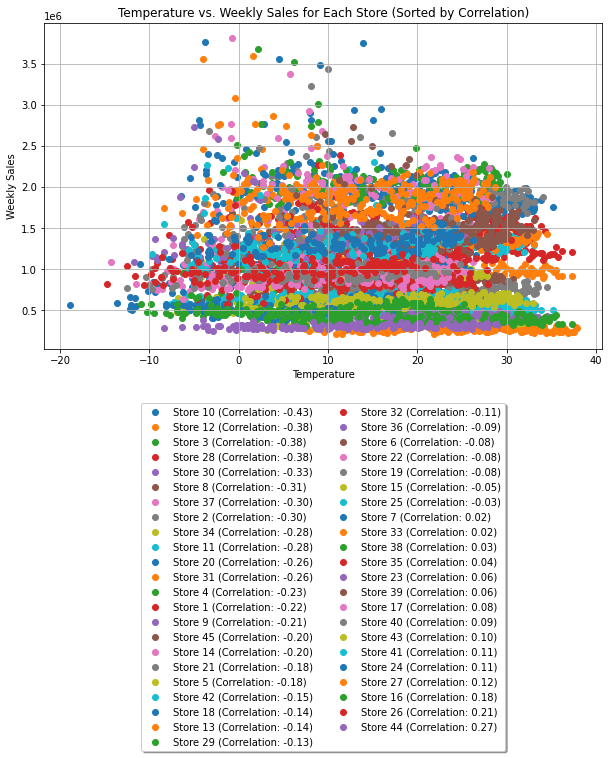

In [13]:
# store-wise correlation between temperature and weekly sales

correlation_by_store_WT = df.groupby('Store').apply(lambda x: x['Temperature'].corr(x['Weekly_Sales']))

# Sort stores based on correlation value in descending order
sorted_stores_WT = correlation_by_store_WT.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
for store_id, corr in sorted_stores_WT.items():
    store_data_WT = df[df['Store'] == store_id]
    plt.scatter(store_data_WT['Temperature'], store_data_WT['Weekly_Sales'], label=f'Store {store_id} (Correlation: {corr:.2f})')

plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.title('Temperature vs. Weekly Sales for Each Store (Sorted by Correlation)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.grid(True)
plt.show()

Note: Most negative correlation is for store 10 with value of -0.43. Thus, this store is worst affected by the temperature.

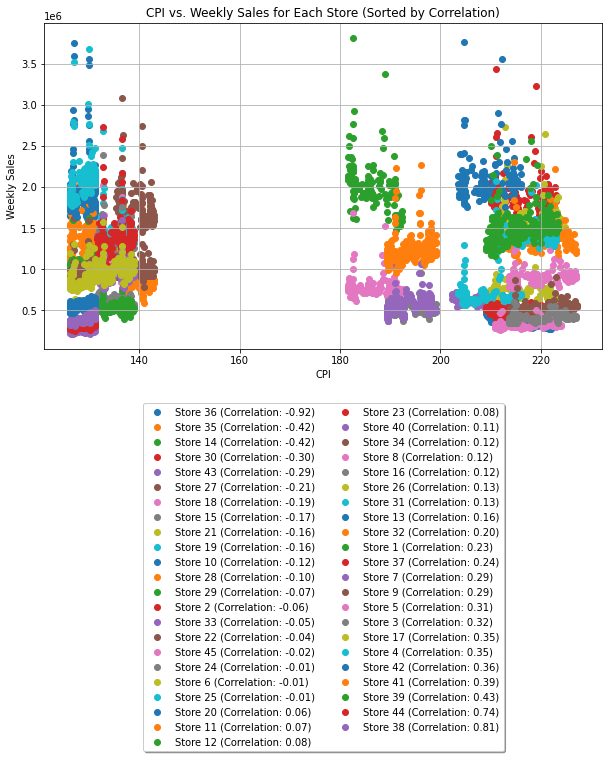

In [14]:
# store-wise correlation between CPI and weekly sales

correlation_by_store_CPI = df.groupby('Store').apply(lambda x: x['CPI'].corr(x['Weekly_Sales']))

# Sort stores based on correlation value in descending order
sorted_stores_CPI = correlation_by_store_CPI.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
for store_id, corr in sorted_stores_CPI.items():
    store_data_CPI = df[df['Store'] == store_id]
    plt.scatter(store_data_CPI['CPI'], store_data_CPI['Weekly_Sales'], label=f'Store {store_id} (Correlation: {corr:.2f})')

plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
plt.title('CPI vs. Weekly Sales for Each Store (Sorted by Correlation)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.grid(True)
plt.show()

Note: Most negative correlation is for store 36 with value of -0.92. Thus, this store is worst affected by the CPI.

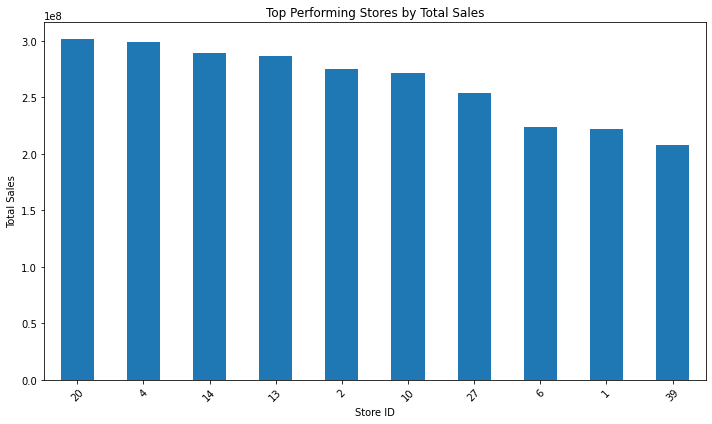

In [15]:
# Top performing stores according to the historical data. Meaning highest weekly sales.

# Calculate total sales for each store
total_sales = df.groupby('Store')['Weekly_Sales'].sum()

# Rank stores by total sales (in descending order)
ranked_stores = total_sales.sort_values(ascending=False)

# Define the number of top-performing stores you want to select
num_top_stores = 10  # Change this number according to your requirement

# Select top performing stores
top_performing_stores = ranked_stores.head(num_top_stores)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
top_performing_stores.plot(kind='bar')
plt.title('Top Performing Stores by Total Sales')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


Note: Top performing stores is 20 and 4.

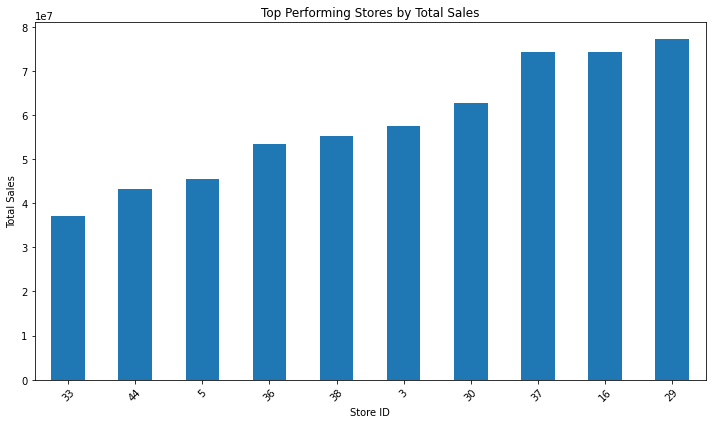

In [16]:
# The worst performing store, and how significant is the difference between the highest and lowest performing stores.

# Calculate total sales for each store
total_sales = df.groupby('Store')['Weekly_Sales'].sum()

# Rank stores by total sales (in descending order)
ranked_stores = total_sales.sort_values(ascending=True)

# Define the number of top-performing stores you want to select
num_worst_stores = 10  # Change this number according to your requirement

# Select top performing stores
worst_performing_stores = ranked_stores.head(num_worst_stores)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
worst_performing_stores.plot(kind='bar')
plt.title('Top Performing Stores by Total Sales')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()



Note: Worst performing store is 33.

In [17]:
# Calculate total sales for each store
total_sales = df.groupby('Store')['Weekly_Sales'].sum()

# Find the worst-performing store (store with the lowest total sales)
worst_performing_store = total_sales.idxmin()
worst_performing_sales = total_sales.min()

# Find the best-performing store (store with the highest total sales)
best_performing_store = total_sales.idxmax()
best_performing_sales = total_sales.max()

# Calculate the difference in sales between the highest and lowest performing stores
difference_sales = best_performing_sales - worst_performing_sales

# Display the worst-performing store and the difference in sales
print("Best Performing Store:")
print(f"Store ID: {best_performing_store}, Total Sales: {best_performing_sales}")
print()
print("Worst Performing Store:")
print(f"Store ID: {worst_performing_store}, Total Sales: {worst_performing_sales}")
print()
print("Difference in Sales between Highest and Lowest Performing Stores:")
print(difference_sales)

Best Performing Store:
Store ID: 20, Total Sales: 301397792.46

Worst Performing Store:
Store ID: 33, Total Sales: 37160221.96

Difference in Sales between Highest and Lowest Performing Stores:
264237570.49999997


<Figure size 432x288 with 0 Axes>

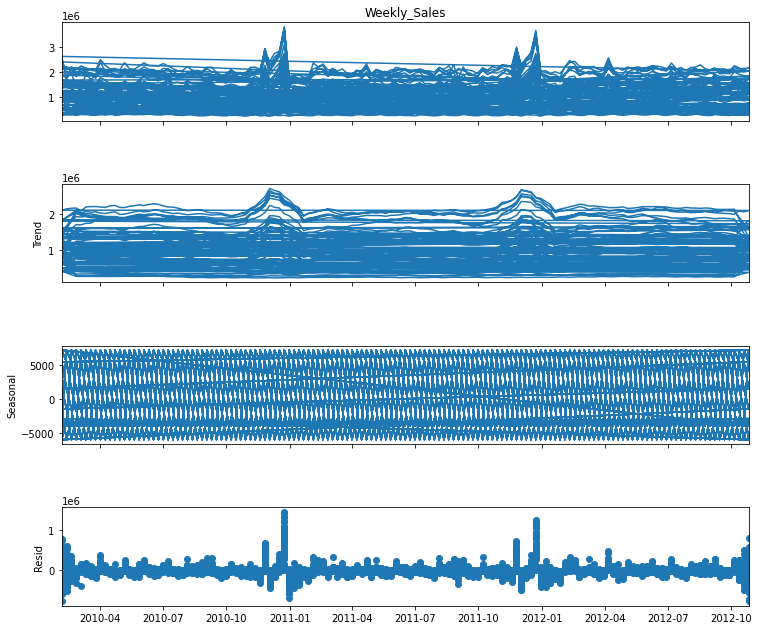

In [18]:
# Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks.

decomposition = seasonal_decompose(df['Weekly_Sales'], period = 7)

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

Note: There is some trend and residual/variation that can be observed in the data around the months of november, december. This is due to rise in weekly sales during this period of holidays. Thus, with this curve data does not look stationary.

In [19]:
# Dickey Fuller test to understand if the data is stationary or not.
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF test statistics', 'p-value', 'Lags used', 'No. of observation used']
    for value, label in zip(result, labels):
        print (label + ':' + str(value))
        
adfuller_test(df['Weekly_Sales'])

ADF test statistics:-4.624149498578304
p-value:0.00011655869699901207
Lags used:34
No. of observation used:6400


Note: Since p-value < 0.05, the data is stationary as per Dickey-Fuller test.

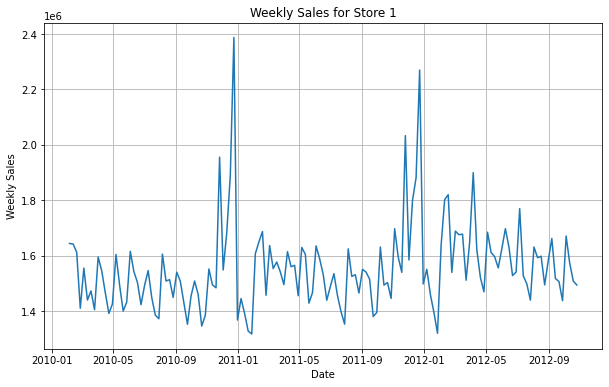

In [20]:
# Extract weekly sales data for store 1 and do the forecasting.

store_1_data = df[df['Store'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(store_1_data.index, store_1_data['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Store 1')
plt.grid(True)
plt.show()

<Figure size 432x288 with 0 Axes>

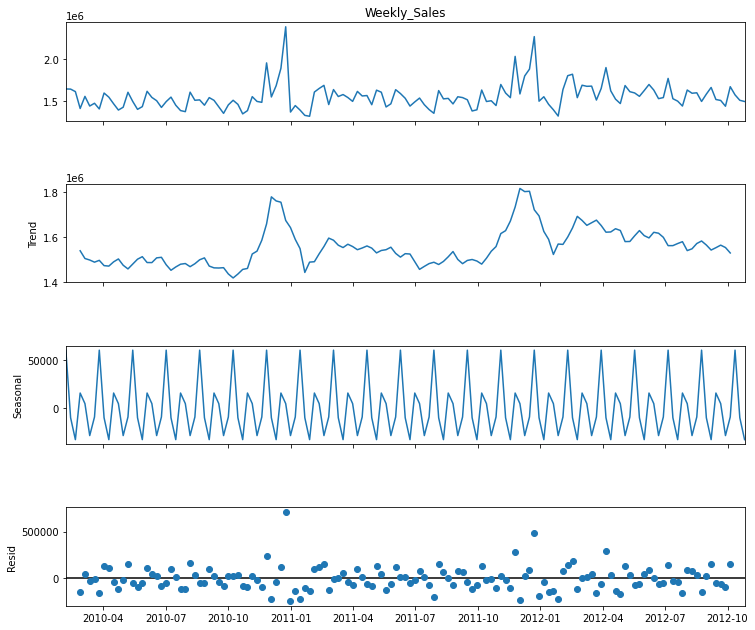

In [21]:
decomposition = seasonal_decompose(store_1_data['Weekly_Sales'], period = 7)

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

Note: There is some trend and residual/variation that can be observed in the store 1 data also, around the months of november, december. This is due to rise in weekly sales during this period of holidays. Thus, with this curve data does not look stationary.

In [22]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF test statistics', 'p-value', 'Lags used', 'No. of observation used']
    for value, label in zip(result, labels):
        print (label + ':' + str(value))
        
adfuller_test(store_1_data['Weekly_Sales'])

ADF test statistics:-5.102186145192285
p-value:1.3877788330759535e-05
Lags used:4
No. of observation used:138


Note: Since p-value < 0.05, the data is stationary as per Dickey-Fuller test.

In [23]:
store_1_data_weekly_sales = pd.DataFrame(store_1_data['Weekly_Sales'])
store_1_data_weekly_sales.head()

Weekly_Sales
Date                    
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68

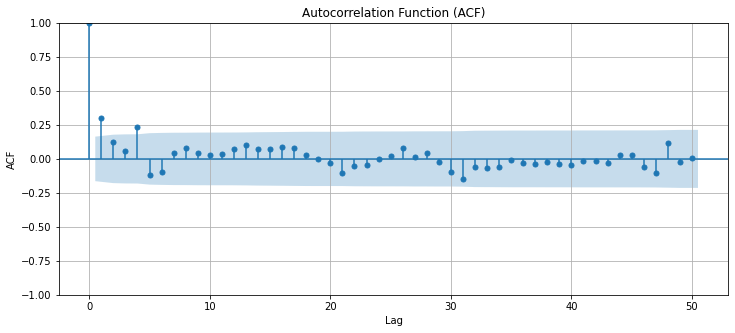

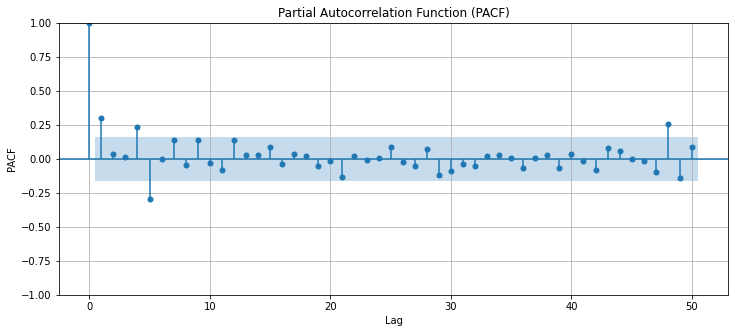

In [24]:
# ARIMA model

# Plot ACF
plt.figure(figsize=(12, 5))
plot_acf(store_1_data_weekly_sales['Weekly_Sales'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 5))
plot_pacf(store_1_data_weekly_sales['Weekly_Sales'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()


Note: p and q values 2 and 2 respectively.

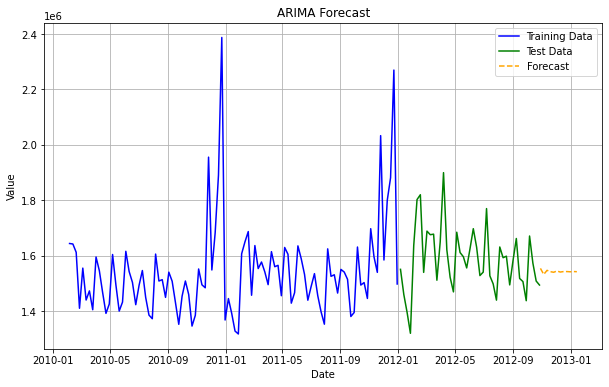

In [25]:

train = store_1_data_weekly_sales.iloc[:-43]
test = store_1_data_weekly_sales.iloc[-43:]

def train_test_arima_model(train, test, p, d, q, forecast_period=12):
    """
    Train and test ARIMA model.

    Parameters:
        train_data (pandas.Series): Series containing training data.
        test_data (pandas.Series): Series containing testing data.
        p (int): AR order.
        d (int): Differencing order.
        q (int): MA order.
        forecast_period (int): Number of periods to forecast.

    Returns:
        pandas.Series: Forecasted values.
    """
    
    # Fit ARIMA model on training data
    model = ARIMA(train, order=(p, d, q))
    fit_model = model.fit()
    forecast = fit_model.forecast(len(test))

    # Forecast for next forecast_period weeks
    future_forecast = fit_model.forecast(steps=forecast_period)

    return forecast, future_forecast

# Example usage:
# Assuming train_data and test_data are already defined
# Assuming p, d, q values are already chosen

forecast, future_forecast = train_test_arima_model(train, test, 2, 0, 2, forecast_period=12)

# Plot actual vs forecasted
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
forecast_index = pd.date_range(start=test.index[-1], periods=len(future_forecast), freq='W')
plt.plot(forecast_index, future_forecast, label='Forecast', color='orange', linestyle='--')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
test.shape

(43, 1)

The model is not performing well.

In [27]:
# Assuming test_data is the actual test data and forecast is the forecasted values
# Compute MAE
mae = mean_absolute_error(test, forecast)

# Compute MSE
mse = mean_squared_error(test, forecast)

# Compute RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 92858.17237839474
MSE: 14871074601.514265
RMSE: 121947.01554984551


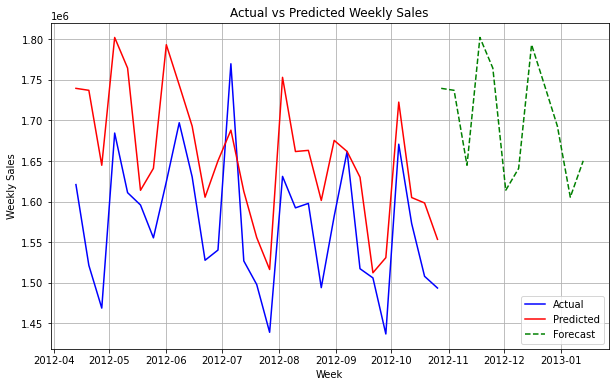

In [28]:
def train_test_sarimax_model(data, test_size=0.2, p=2, d=0, q=2, P=2, D=0, Q=2, s=52, forecast_period=12):
    """
    Train, test, and forecast SARIMAX model.

    Parameters:
        data (pandas.DataFrame): DataFrame containing weekly sales data.
        test_size (float): Proportion of the dataset to include in the test split.
        p (int): AR order.
        d (int): Differencing order.
        q (int): MA order.
        P (int): Seasonal AR order.
        D (int): Seasonal differencing order.
        Q (int): Seasonal MA order.
        s (int): Seasonal period.
        forecast_period (int): Number of periods to forecast into the future.

    Returns:
        tuple: Tuple containing actual, predicted, and forecasted weekly sales data.
    """
    # Split data into train and test sets
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Fit the model on the train data
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
    fit_model = model.fit()

    # Forecast on the test data
    forecast = fit_model.forecast(steps=len(test))  # Adjust forecast length to match test data length

    # Forecast for the next forecast_period weeks
    future_forecast = fit_model.forecast(forecast_period)

    return test['Weekly_Sales'], forecast, future_forecast

# Example usage:
# Assuming store_1_data_weekly_sales is already defined
actual, predicted, future_forecast = train_test_sarimax_model(store_1_data_weekly_sales, test_size=0.2, p=2, d=0, q=2, P=1, D=0, Q=1, s=52, forecast_period=12)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(store_1_data_weekly_sales.index[-len(actual):], actual, label='Actual', color='blue')
plt.plot(store_1_data_weekly_sales.index[-len(predicted):], predicted, label='Predicted', color='red')

# Plot future forecast
forecast_index = pd.date_range(start=store_1_data_weekly_sales.index[-1], periods=len(future_forecast), freq='W')
plt.plot(forecast_index, future_forecast, label='Forecast', color='green', linestyle='--')

plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Compute MAE
mae = mean_absolute_error(actual, predicted)

# Compute MSE
mse = mean_squared_error(actual, predicted)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)


MAE: 88192.51495916113
MSE: 10132441469.201645
RMSE: 100660.02915359028
MAPE: 5.648348064763347


RMSE less than ARIMA. Performing better than ARIMA.

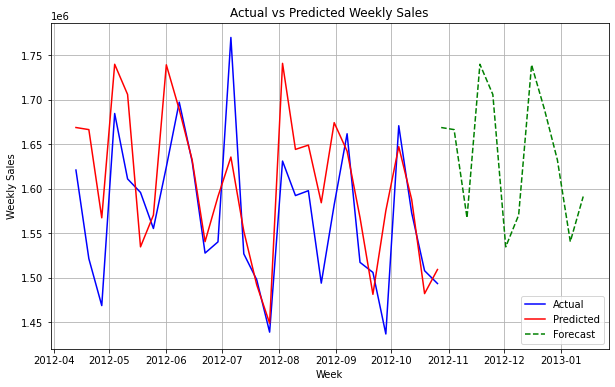

In [30]:
def train_test_forecast_model(data, test_size=0.2, forecast_period=12):
    """
    Train, test, and forecast Holt-Winters Exponential Smoothing model.

    Parameters:
        data (pandas.DataFrame): DataFrame containing weekly sales data.
        test_size (float): Proportion of the dataset to include in the test split.
        forecast_period (int): Number of weeks to forecast into the future.

    Returns:
        tuple: Tuple containing actual, predicted, and forecasted weekly sales data.
    """
    # Split data into train and test sets
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Fit the model on the train data
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52)
    fit_model = model.fit()

    # Forecast on the test data
    forecast = fit_model.forecast(len(test))  # Adjust forecast length to match test data length

    # Forecast for the next forecast_period weeks
    future_forecast = fit_model.forecast(forecast_period)

    return test['Weekly_Sales'], forecast, future_forecast

# Example usage:
# Assuming store_1_weekly_sales is already defined
actual, predicted, future_forecast = train_test_forecast_model(store_1_data_weekly_sales)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(store_1_data_weekly_sales.index[-len(actual):], actual, label='Actual', color='blue')
plt.plot(store_1_data_weekly_sales.index[-len(predicted):], predicted, label='Predicted', color='red')

# Plot future forecast
forecast_index = pd.date_range(start=store_1_data_weekly_sales.index[-1], periods=len(future_forecast), freq='W')
plt.plot(forecast_index, future_forecast, label='Forecast', color='green', linestyle='--')

plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


In [31]:

# Compute MAE
mae = mean_absolute_error(actual, predicted)

# Compute MSE
mse = mean_squared_error(actual, predicted)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)


MAE: 54782.405896411336
MSE: 4897726087.842085
RMSE: 69983.75588550592
MAPE: 3.488178374702215


RMSE is even lesser than SARIMAX method. Holt Winter exponential smoothing algorithm by far looks better than ARIMA and SARIMAX.

In [32]:
def train_test_forecast_model(data, test_size=0.2, forecast_period=12):
    """
    Train, test, and forecast Holt-Winters Exponential Smoothing model.

    Parameters:
        data (pandas.DataFrame): DataFrame containing weekly sales data.
        test_size (float): Proportion of the dataset to include in the test split.
        forecast_period (int): Number of weeks to forecast into the future.

    Returns:
        pandas.DataFrame: DataFrame containing test data, predicted data, and difference in weekly sales.
    """
    # Split data into train and test sets
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Fit the model on the train data
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52)
    fit_model = model.fit()

    # Forecast on the test data
    forecast = fit_model.forecast(steps = len(test))  # Adjust forecast length to match test data length

    # Calculate the difference between actual and predicted
    difference = test['Weekly_Sales'] - forecast

    # Create a DataFrame
    results_df = pd.DataFrame({
        'Actual': test['Weekly_Sales'],
        'Predicted': forecast,
        'Difference': difference
    })

    return results_df

# Example usage:
# Assuming store_1_weekly_sales is already defined
results_df = train_test_forecast_model(store_1_data_weekly_sales)
print(results_df)



                Actual     Predicted     Difference
2012-04-13  1621031.70  1.668784e+06  -47752.382272
2012-04-20  1521577.87  1.666441e+06 -144862.803322
2012-04-27  1468928.37  1.567449e+06  -98520.877397
2012-05-04  1684519.99  1.739775e+06  -55254.653389
2012-05-11  1611096.05  1.705880e+06  -94784.427022
2012-05-18  1595901.87  1.534842e+06   61060.348962
2012-05-25  1555444.55  1.570484e+06  -15039.247995
2012-06-01  1624477.58  1.739171e+06 -114693.736076
2012-06-08  1697230.96  1.689051e+06    8179.809079
2012-06-15  1630607.00  1.632441e+06   -1834.480064
2012-06-22  1527845.81  1.540700e+06  -12854.383808
2012-06-29  1540421.49  1.591347e+06  -50925.134415
2012-07-06  1769854.16  1.635651e+06  134203.354104
2012-07-13  1527014.04  1.552439e+06  -25424.857231
2012-07-20  1497954.76  1.492265e+06    5689.860347
2012-07-27  1439123.71  1.449119e+06   -9995.661407
2012-08-03  1631135.79  1.740791e+06 -109654.938146
2012-08-10  1592409.97  1.644224e+06  -51813.788516
2012-08-17  

Still there are cases where difference between the weekly sales predicted by the model is varied from that of the actual sales. Thus, still there is a scope to do improvization in the model. Models such as Nbeats can also be tried for the forecasting. Similarly, the model can be used for forecasting weekly sales in other stores as well.

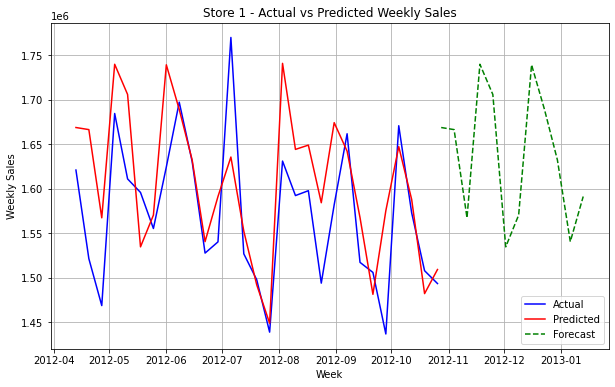

Store 1 - MAE: 54782.405896411336, MSE: 4897726087.842085, RMSE: 69983.75588550592, MAPE: 3.488178374702215


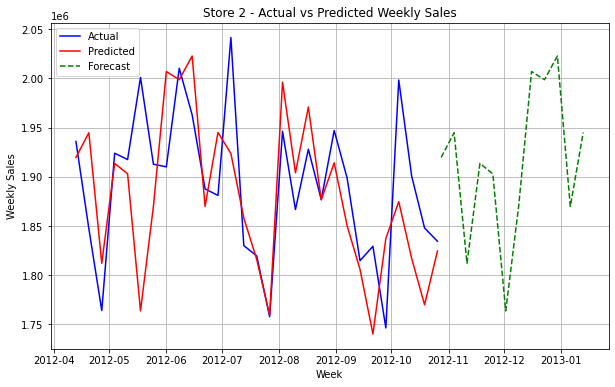

Store 2 - MAE: 53880.92600263247, MSE: 5395210735.948374, RMSE: 73452.09824061103, MAPE: 2.819335328795335


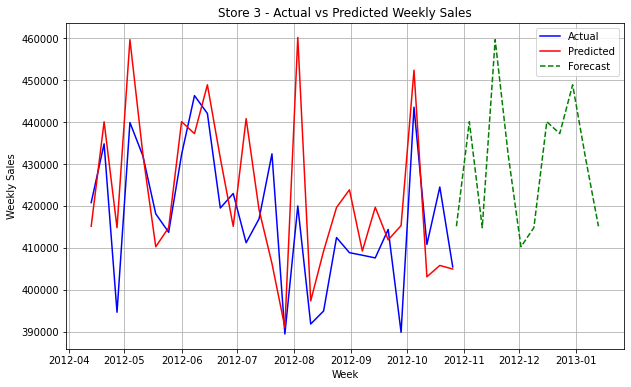

Store 3 - MAE: 11123.209064882232, MSE: 217600814.21253046, RMSE: 14751.298729689208, MAPE: 2.6722808443478514


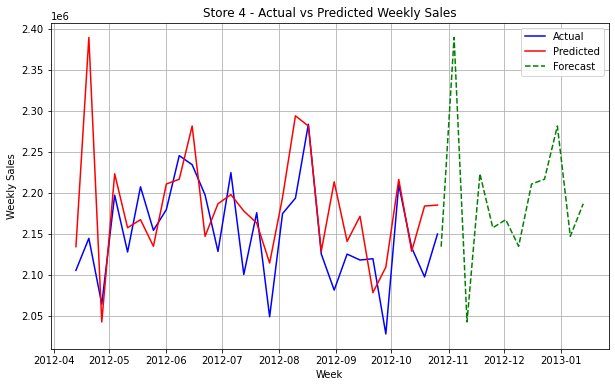

Store 4 - MAE: 47990.07640420045, MSE: 4630468728.1095705, RMSE: 68047.54755396825, MAPE: 2.2506853441433035


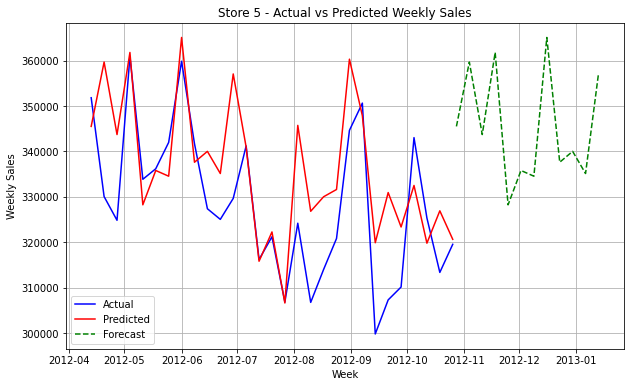

Store 5 - MAE: 10519.933516412008, MSE: 185469355.4385011, RMSE: 13618.713428165713, MAPE: 3.2558721281690373


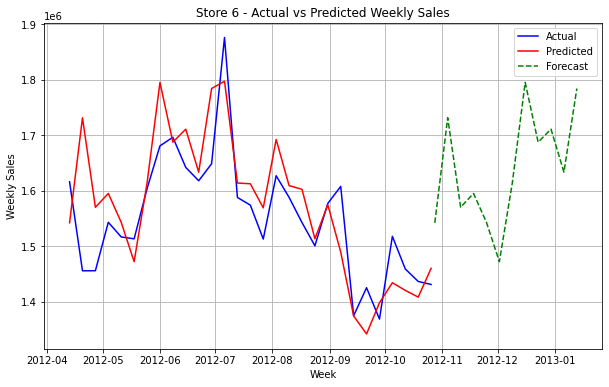

Store 6 - MAE: 58899.12103787607, MSE: 6486784237.671765, RMSE: 80540.57510144664, MAPE: 3.800763740259662


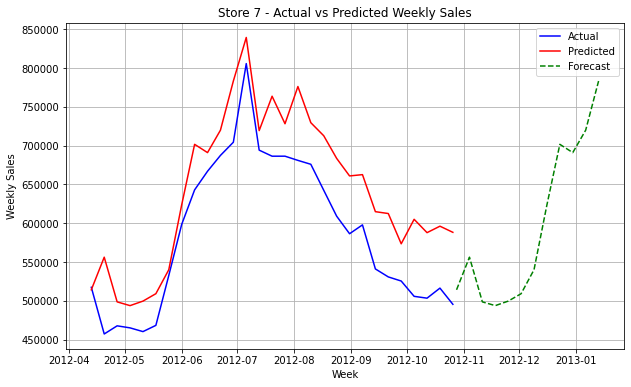

Store 7 - MAE: 56494.9541754661, MSE: 3955791460.281432, RMSE: 62895.08295790246, MAPE: 9.962154791001293


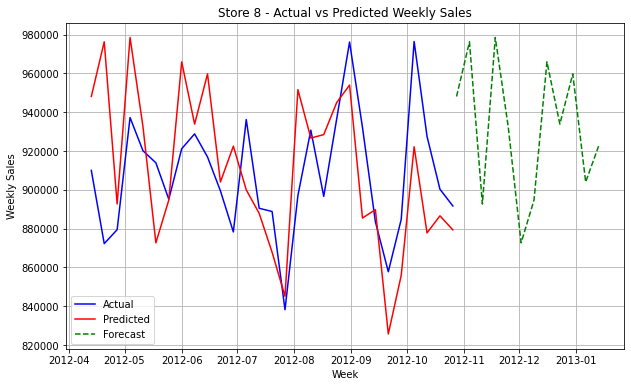

Store 8 - MAE: 28408.21233203281, MSE: 1311772356.3211935, RMSE: 36218.398036373634, MAPE: 3.1267638270222866


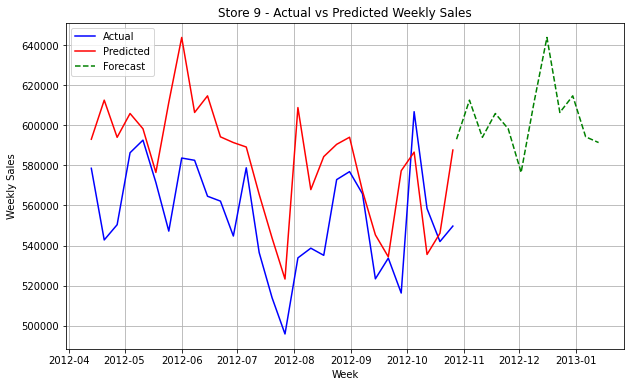

Store 9 - MAE: 30665.798778387703, MSE: 1381148868.4155645, RMSE: 37163.81127408173, MAPE: 5.596198109679694


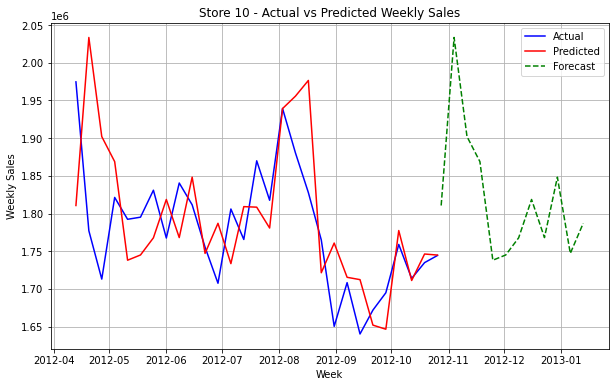

Store 10 - MAE: 63665.28037672433, MSE: 7532731710.321715, RMSE: 86791.3112605272, MAPE: 3.5696428840790655


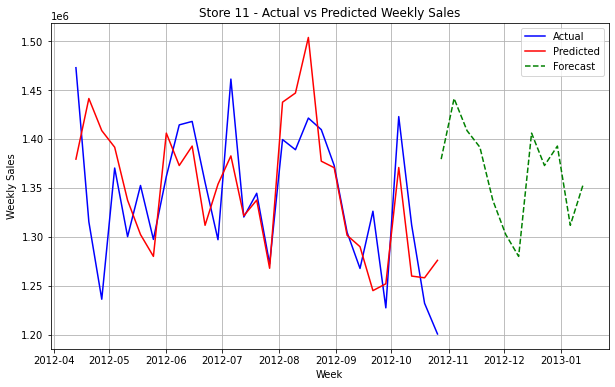

Store 11 - MAE: 47230.04972670378, MSE: 3678392567.202129, RMSE: 60649.75323282139, MAPE: 3.5337297021134124


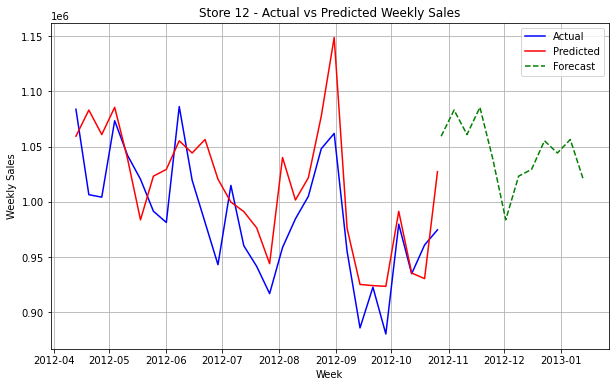

Store 12 - MAE: 35767.07201128808, MSE: 1866083564.5915706, RMSE: 43198.18936705068, MAPE: 3.6383856526642804


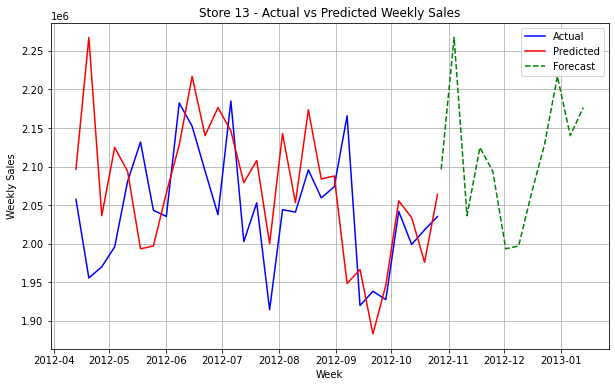

Store 13 - MAE: 69557.6367277388, MSE: 9026334916.705168, RMSE: 95007.02561760982, MAPE: 3.411424991459614


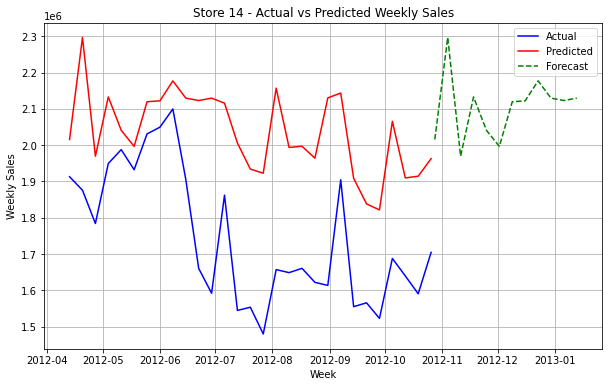

Store 14 - MAE: 291266.3954570808, MSE: 105295056848.90549, RMSE: 324491.99812769727, MAPE: 17.510563712157783


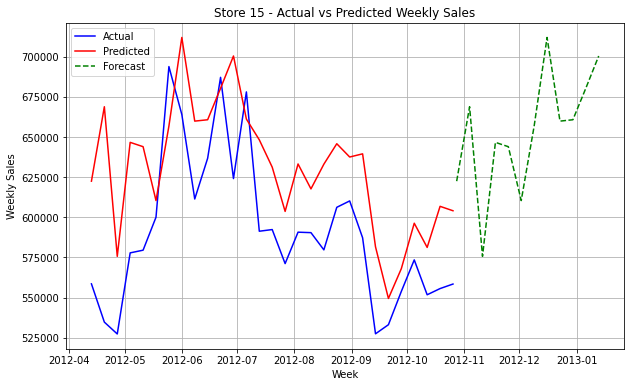

Store 15 - MAE: 43137.85096224072, MSE: 2475836920.8298492, RMSE: 49757.78251519906, MAPE: 7.436501423322205


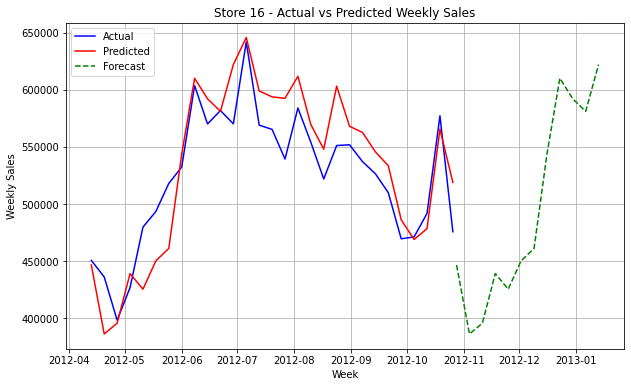

Store 16 - MAE: 24931.967382822142, MSE: 939665414.9859554, RMSE: 30653.962467941325, MAPE: 4.812101306268557


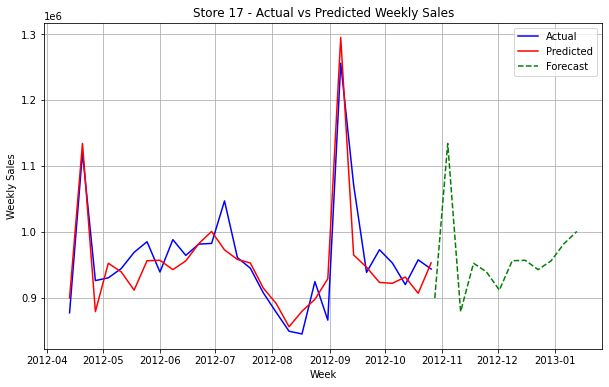

Store 17 - MAE: 28579.737219579336, MSE: 1418577259.7590356, RMSE: 37664.00482900133, MAPE: 2.9392822128662117


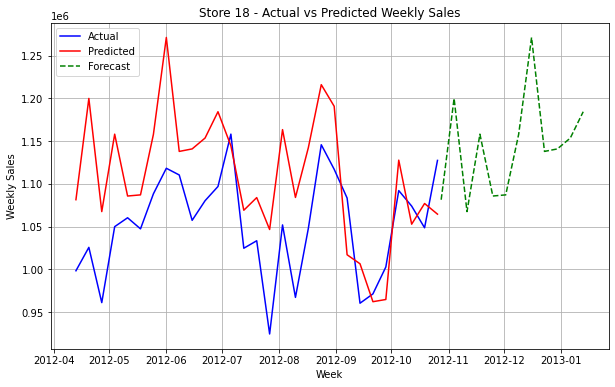

Store 18 - MAE: 70227.48515782302, MSE: 6587899243.089685, RMSE: 81165.87486801141, MAPE: 6.733867186232397


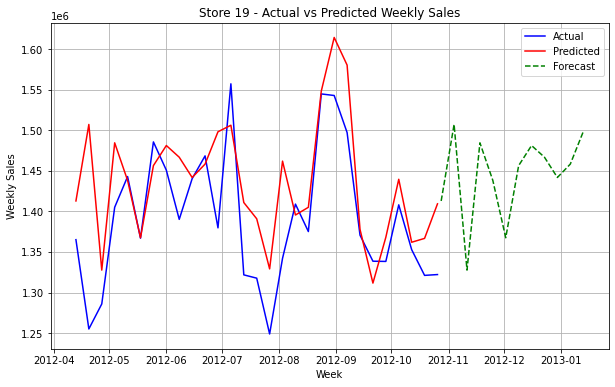

Store 19 - MAE: 53239.16961459617, MSE: 5440332312.357319, RMSE: 73758.6083949346, MAPE: 3.9286237141327516


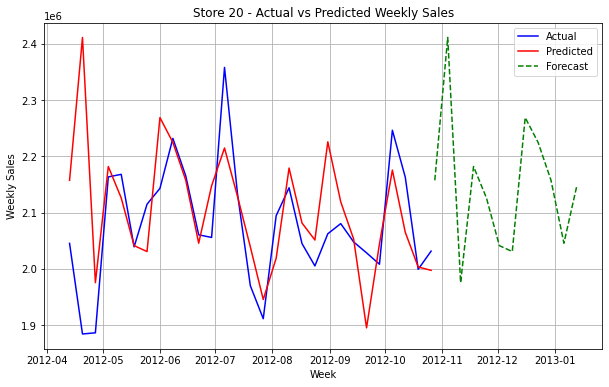

Store 20 - MAE: 74152.09876048959, MSE: 14888669301.340378, RMSE: 122019.1349802988, MAPE: 3.643531463854128


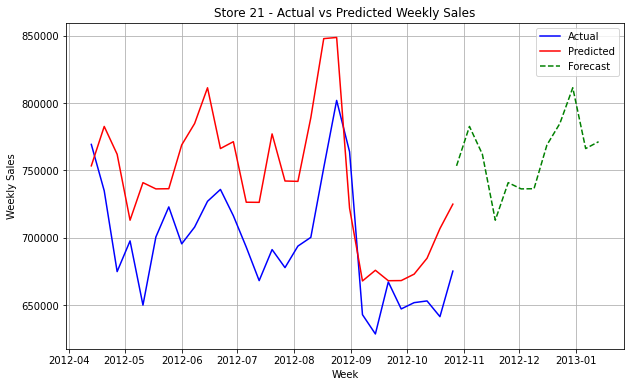

Store 21 - MAE: 50082.498816719075, MSE: 3220458962.234987, RMSE: 56749.08776566357, MAPE: 7.2115927001596


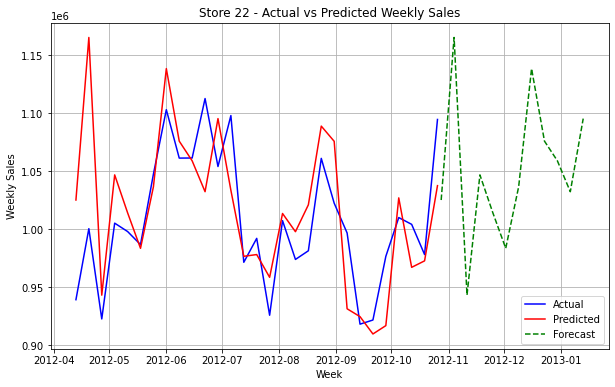

Store 22 - MAE: 35998.06113086433, MSE: 2443659104.373615, RMSE: 49433.380466781906, MAPE: 3.551513449041287


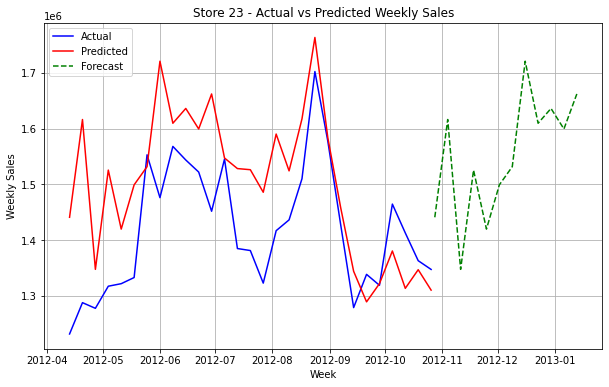

Store 23 - MAE: 104844.00292107536, MSE: 17415193934.444454, RMSE: 131966.639475454, MAPE: 7.597276968631482


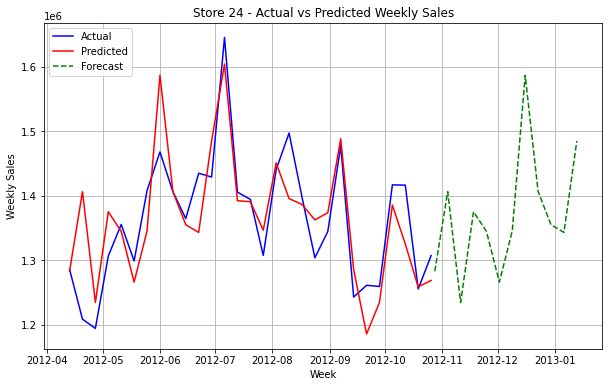

Store 24 - MAE: 45463.27105042444, MSE: 3913476296.3180876, RMSE: 62557.78365893478, MAPE: 3.3710554593789306


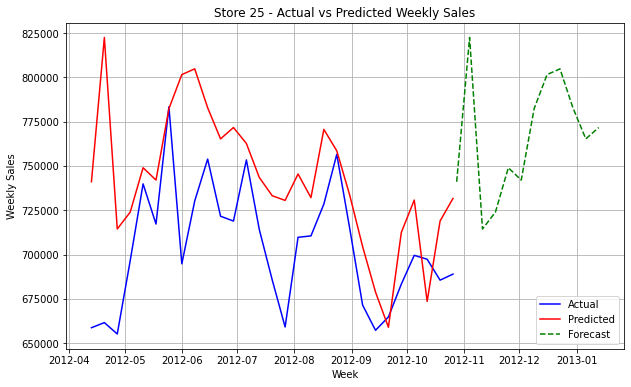

Store 25 - MAE: 40349.49637331464, MSE: 2732065329.9811506, RMSE: 52269.16232331594, MAPE: 5.84787758546554


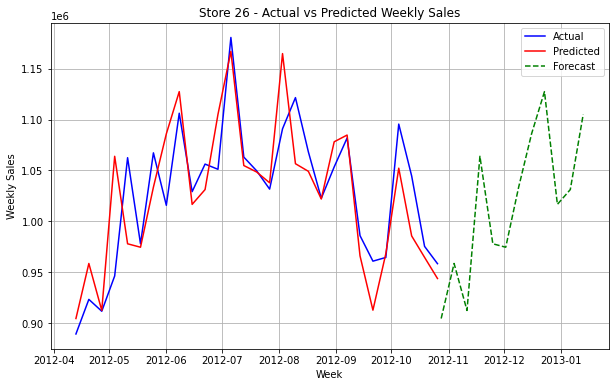

Store 26 - MAE: 30574.384638471733, MSE: 1787833974.3462856, RMSE: 42282.78579216707, MAPE: 2.972303345186664


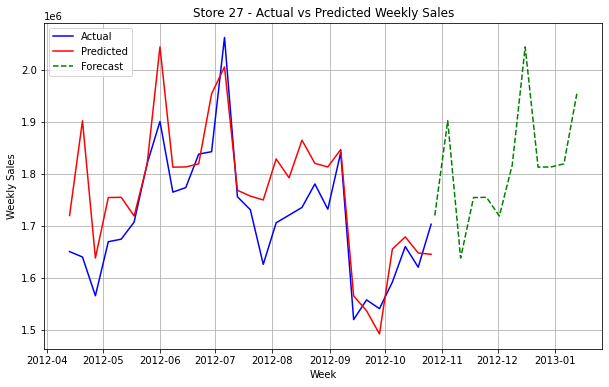

Store 27 - MAE: 65380.91116130863, MSE: 7160695820.0039425, RMSE: 84620.89470103671, MAPE: 3.840872027433092


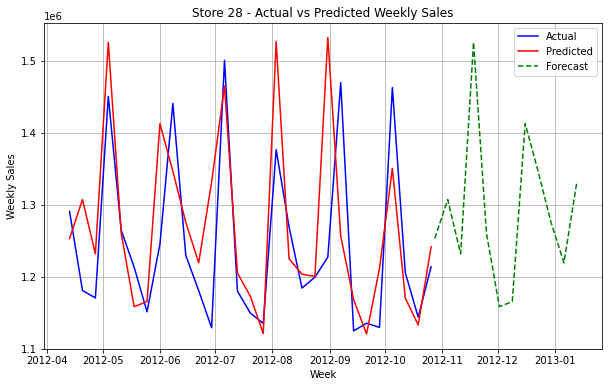

Store 28 - MAE: 71712.80295411745, MSE: 10387715638.89085, RMSE: 101920.14344029766, MAPE: 5.673462810209524


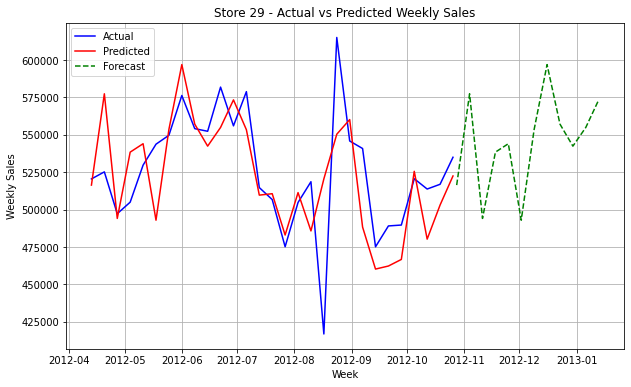

Store 29 - MAE: 23659.993703172597, MSE: 1067206560.2279975, RMSE: 32668.12758986957, MAPE: 4.598780157232439


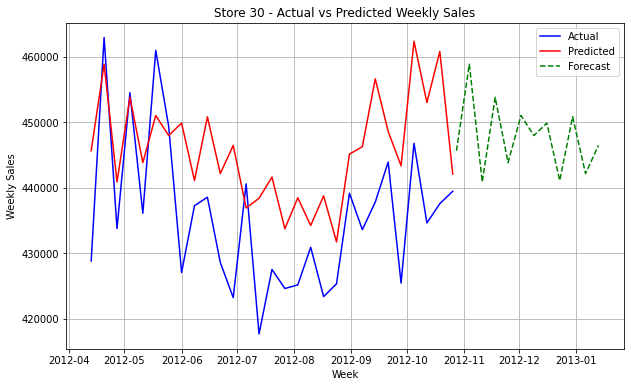

Store 30 - MAE: 11360.113835923006, MSE: 176972032.97793615, RMSE: 13303.083589075735, MAPE: 2.630092501710967


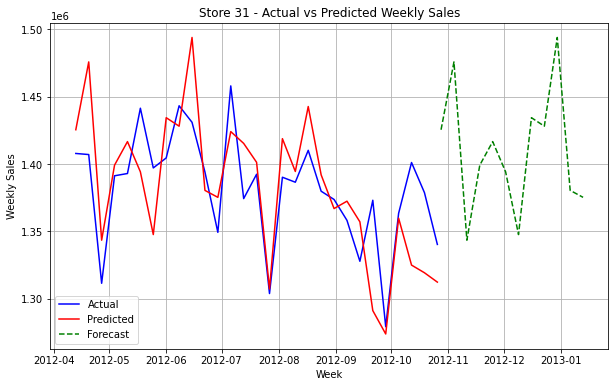

Store 31 - MAE: 29950.55923394186, MSE: 1393007149.4009461, RMSE: 37323.010990553084, MAPE: 2.154556911148772


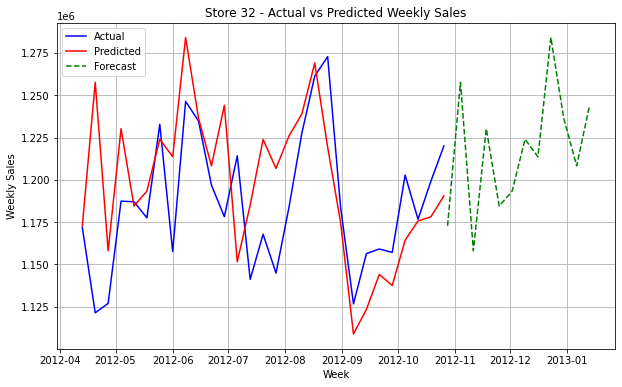

Store 32 - MAE: 32231.31154068988, MSE: 1836683288.4783142, RMSE: 42856.54312328882, MAPE: 2.743909642471518


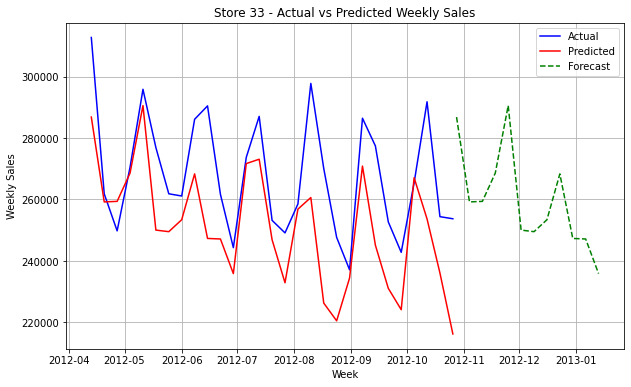

Store 33 - MAE: 17605.12389357233, MSE: 483649792.69885755, RMSE: 21992.039302867244, MAPE: 6.4822301017309485


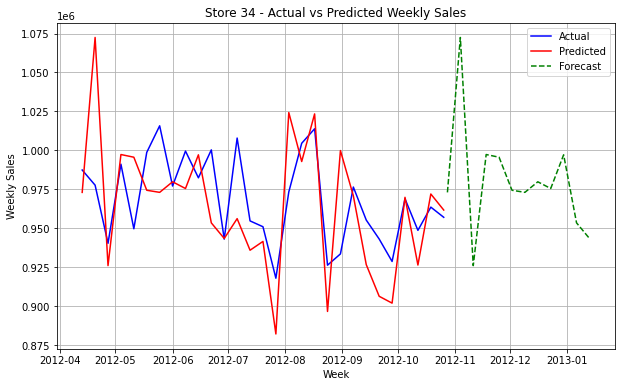

Store 34 - MAE: 25854.64447855941, MSE: 1137859638.2647505, RMSE: 33732.175119086976, MAPE: 2.673370943298496


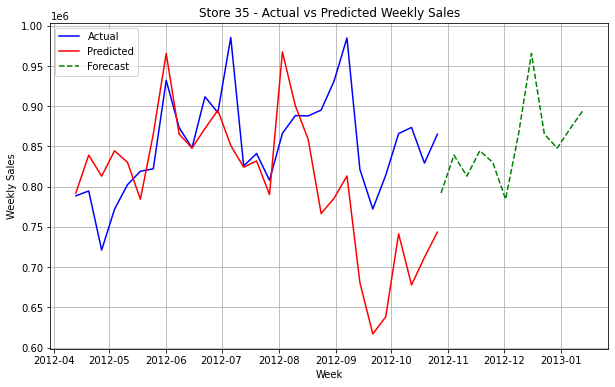

Store 35 - MAE: 75358.97073418074, MSE: 9534763750.09304, RMSE: 97646.11487454604, MAPE: 8.797765468743314


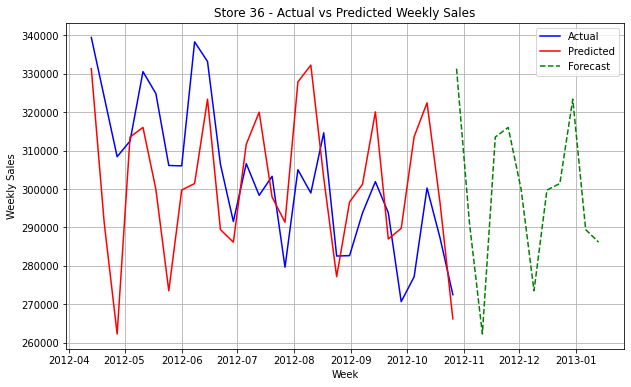

Store 36 - MAE: 16965.590223282987, MSE: 426341875.8230679, RMSE: 20648.047748469293, MAPE: 5.579995415065778


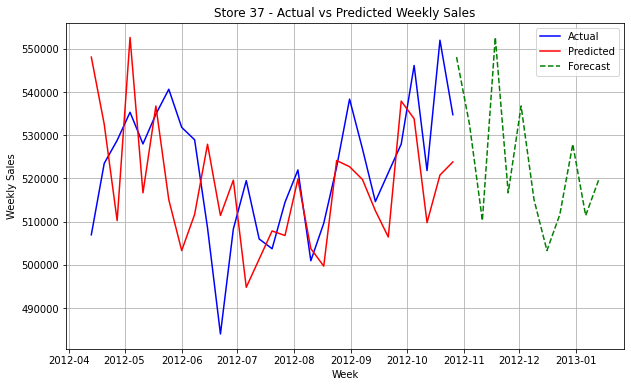

Store 37 - MAE: 13863.8598995462, MSE: 289164860.5811663, RMSE: 17004.848149312194, MAPE: 2.6524067241521987


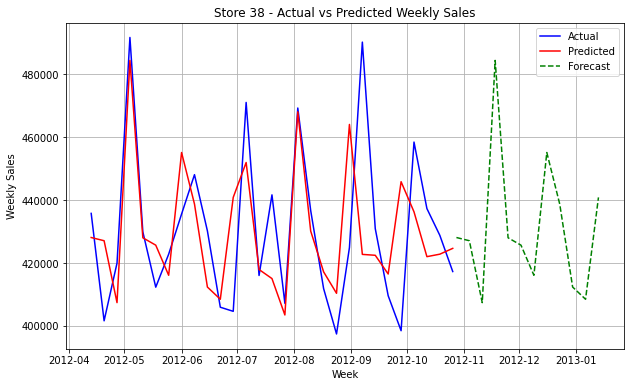

Store 38 - MAE: 15802.61325073412, MSE: 478155004.680502, RMSE: 21866.75569627333, MAPE: 3.654163879946736


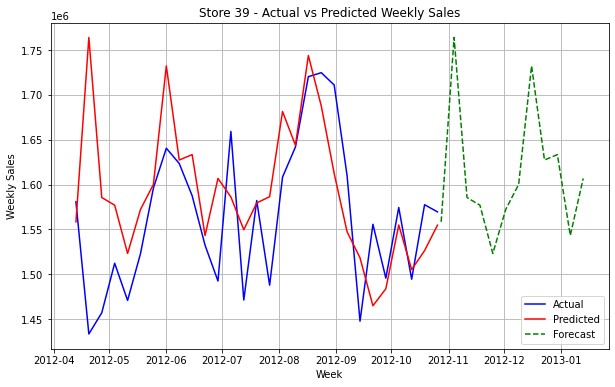

Store 39 - MAE: 59925.818616627155, MSE: 7526101261.310375, RMSE: 86753.10519693446, MAPE: 3.922215393985558


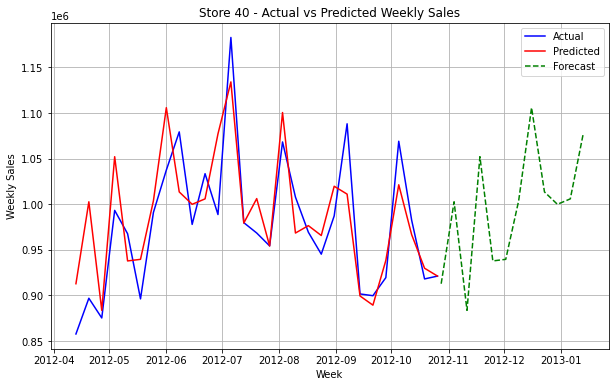

Store 40 - MAE: 34108.17714041392, MSE: 1923493389.5642836, RMSE: 43857.64915683789, MAPE: 3.4469778106029176


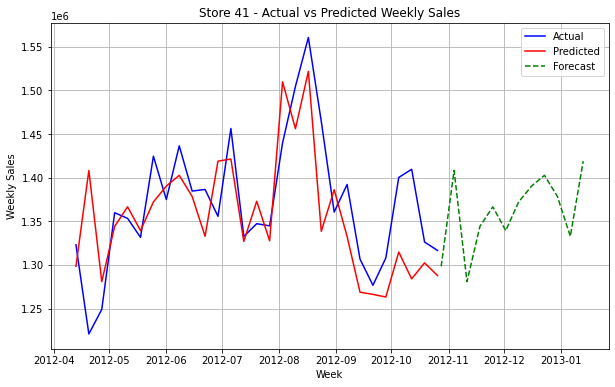

Store 41 - MAE: 45317.66061744312, MSE: 3701778080.5727243, RMSE: 60842.23927973661, MAPE: 3.3141281308109303


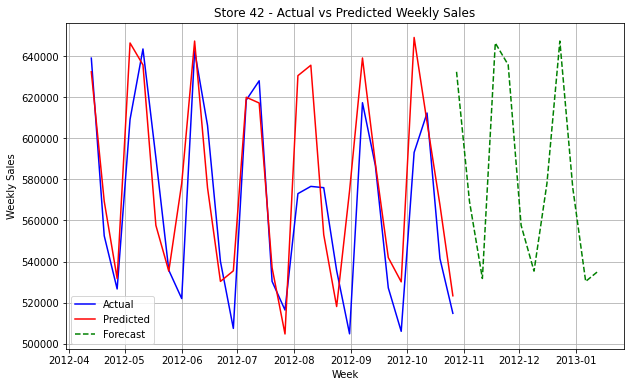

Store 42 - MAE: 22417.526992239378, MSE: 890889436.9126166, RMSE: 29847.771054345358, MAPE: 4.020487772122327


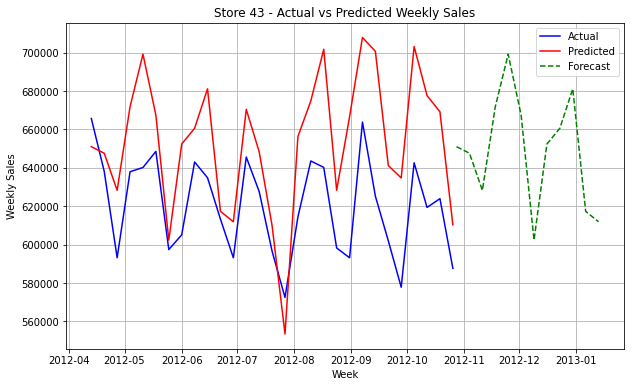

Store 43 - MAE: 35463.74052706282, MSE: 1656924906.1638925, RMSE: 40705.34247692669, MAPE: 5.722592583274885


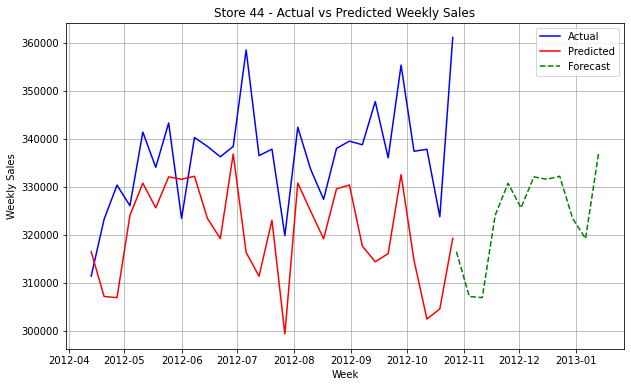

Store 44 - MAE: 16945.650027132244, MSE: 400808341.5607001, RMSE: 20020.198339694343, MAPE: 4.986235876763756


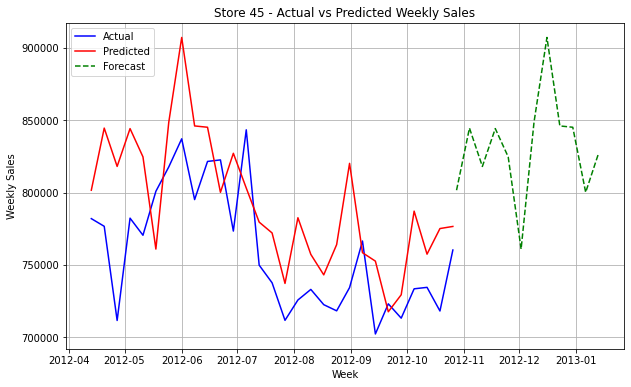

Store 45 - MAE: 41208.6984530655, MSE: 2240568901.066968, RMSE: 47334.64799770849, MAPE: 5.451213338676272


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the function to process and forecast for a given store
def train_test_forecast_model(data, test_size=0.2, forecast_period=12):
    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52)
    fit_model = model.fit()
    forecast = fit_model.forecast(len(test))
    future_forecast = fit_model.forecast(forecast_period)
    return test['Weekly_Sales'], forecast, future_forecast

# Define the function to apply the forecasting for all stores
def forecast_all_stores(df, num_stores=45):
    results = []
    for store in range(1, num_stores + 1):
        store_data = df[df['Store'] == store]
        store_data_weekly_sales = pd.DataFrame(store_data['Weekly_Sales'])
        
        actual, predicted, future_forecast = train_test_forecast_model(store_data_weekly_sales)
        
        # Collect metrics
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100

        results.append({
            'Store': store,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'Future Forecast': future_forecast
        })
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(store_data_weekly_sales.index[-len(actual):], actual, label='Actual', color='blue')
        plt.plot(store_data_weekly_sales.index[-len(predicted):], predicted, label='Predicted', color='red')
        forecast_index = pd.date_range(start=store_data_weekly_sales.index[-1], periods=len(future_forecast), freq='W')
        plt.plot(forecast_index, future_forecast, label='Forecast', color='green', linestyle='--')
        
        plt.title(f'Store {store} - Actual vs Predicted Weekly Sales')
        plt.xlabel('Week')
        plt.ylabel('Weekly Sales')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        print(f"Store {store} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")

    return results

# Example usage with your dataset
forecast_results = forecast_all_stores(df)

# forecast_results will contain metrics and future forecasts for each store


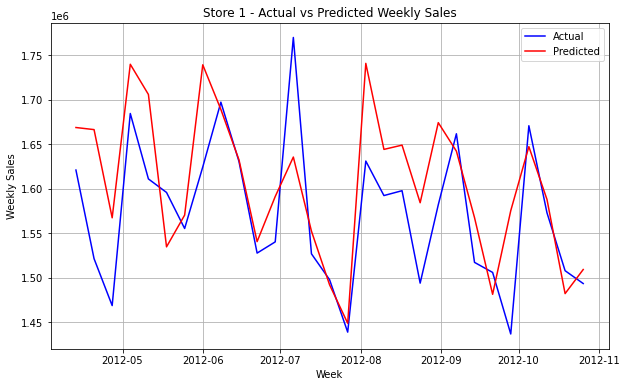

Store 1 results:
                Actual     Predicted     Difference
2012-04-13  1621031.70  1.668784e+06  -47752.382272
2012-04-20  1521577.87  1.666441e+06 -144862.803322
2012-04-27  1468928.37  1.567449e+06  -98520.877397
2012-05-04  1684519.99  1.739775e+06  -55254.653389
2012-05-11  1611096.05  1.705880e+06  -94784.427022
2012-05-18  1595901.87  1.534842e+06   61060.348962
2012-05-25  1555444.55  1.570484e+06  -15039.247995
2012-06-01  1624477.58  1.739171e+06 -114693.736076
2012-06-08  1697230.96  1.689051e+06    8179.809079
2012-06-15  1630607.00  1.632441e+06   -1834.480064
2012-06-22  1527845.81  1.540700e+06  -12854.383808
2012-06-29  1540421.49  1.591347e+06  -50925.134415
2012-07-06  1769854.16  1.635651e+06  134203.354104
2012-07-13  1527014.04  1.552439e+06  -25424.857231
2012-07-20  1497954.76  1.492265e+06    5689.860347
2012-07-27  1439123.71  1.449119e+06   -9995.661407
2012-08-03  1631135.79  1.740791e+06 -109654.938146
2012-08-10  1592409.97  1.644224e+06  -51813.78

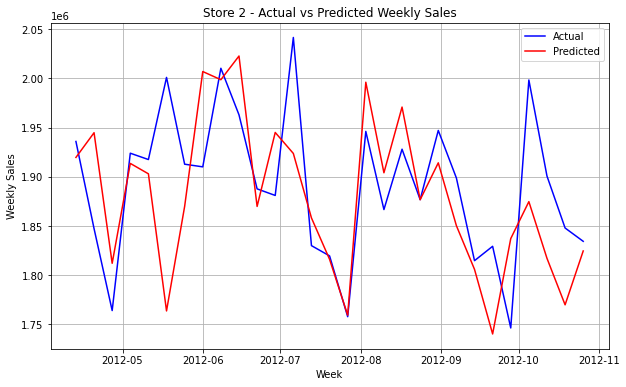

Store 2 results:
                Actual     Predicted     Difference
2012-04-13  1935869.10  1.919679e+06   16190.458470
2012-04-20  1847344.45  1.944761e+06  -97416.231831
2012-04-27  1764133.09  1.812145e+06  -48012.133782
2012-05-04  1923957.09  1.913601e+06   10355.889834
2012-05-11  1917520.99  1.903020e+06   14501.205001
2012-05-18  2000940.67  1.763760e+06  237180.790726
2012-05-25  1912791.09  1.869928e+06   42862.765668
2012-06-01  1910092.37  2.006902e+06  -96809.650440
2012-06-08  2010216.49  1.998606e+06   11610.861125
2012-06-15  1962924.30  2.022664e+06  -59740.108128
2012-06-22  1887733.21  1.869900e+06   17833.411424
2012-06-29  1881046.12  1.945018e+06  -63972.233370
2012-07-06  2041507.40  1.923703e+06  117804.112002
2012-07-13  1830075.13  1.858199e+06  -28123.854257
2012-07-20  1819666.46  1.816168e+06    3498.580194
2012-07-27  1757923.88  1.759472e+06   -1548.054508
2012-08-03  1946104.64  1.996055e+06  -49950.497605
2012-08-10  1866719.96  1.904084e+06  -37364.31

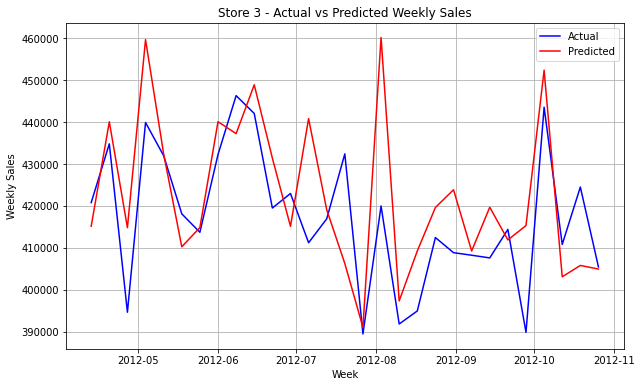

Store 3 results:
               Actual      Predicted    Difference
2012-04-13  420789.74  415147.232277   5642.507723
2012-04-20  434822.13  440091.754089  -5269.624089
2012-04-27  394616.11  414806.309290 -20190.199290
2012-05-04  439913.57  459699.782714 -19786.212714
2012-05-11  431985.36  432419.751663   -434.391663
2012-05-18  418112.76  410252.117422   7860.642578
2012-05-25  413701.29  414830.264359  -1128.974359
2012-06-01  432268.53  440110.455996  -7841.925996
2012-06-08  446336.80  437263.737782   9073.062218
2012-06-15  442074.79  448916.781281  -6841.991281
2012-06-22  419497.95  431421.298243 -11923.348243
2012-06-29  422965.33  415126.028819   7839.301181
2012-07-06  411206.50  440843.243177 -29636.743177
2012-07-13  416913.10  419093.884873  -2180.784873
2012-07-20  432424.85  406245.485832  26179.364168
2012-07-27  389427.90  391013.991451  -1586.091451
2012-08-03  419990.29  460218.864441 -40228.574441
2012-08-10  391811.60  397311.836889  -5500.236889
2012-08-17  39

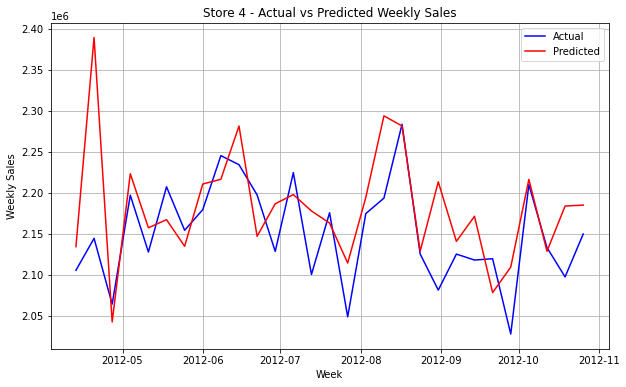

Store 4 results:
                Actual     Predicted     Difference
2012-04-13  2105301.39  2.134163e+06  -28861.693193
2012-04-20  2144336.89  2.389459e+06 -245122.236702
2012-04-27  2064065.66  2.042275e+06   21791.150103
2012-05-04  2196968.33  2.223110e+06  -26141.895884
2012-05-11  2127661.17  2.157250e+06  -29588.459775
2012-05-18  2207214.81  2.167092e+06   40122.338435
2012-05-25  2154137.67  2.134650e+06   19487.769556
2012-06-01  2179360.94  2.210601e+06  -31240.518035
2012-06-08  2245257.18  2.216432e+06   28824.832503
2012-06-15  2234190.93  2.281405e+06  -47214.422383
2012-06-22  2197299.65  2.146805e+06   50494.679566
2012-06-29  2128362.92  2.186513e+06  -58149.970538
2012-07-06  2224499.28  2.197691e+06   26808.540743
2012-07-13  2100252.61  2.177694e+06  -77441.126542
2012-07-20  2175563.69  2.163000e+06   12563.892441
2012-07-27  2048613.65  2.114200e+06  -65586.276171
2012-08-03  2174514.13  2.194266e+06  -19751.520446
2012-08-10  2193367.69  2.293819e+06 -100450.99

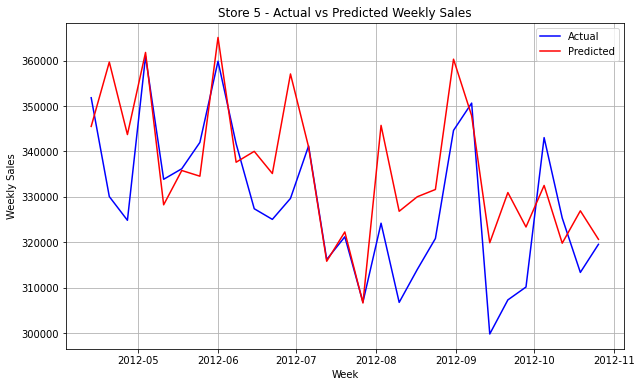

Store 5 results:
               Actual      Predicted    Difference
2012-04-13  351832.03  345517.515176   6314.514824
2012-04-20  330063.06  359687.953515 -29624.893515
2012-04-27  324839.74  343722.271801 -18882.531801
2012-05-04  360932.69  361805.970462   -873.280462
2012-05-11  333870.52  328248.240495   5622.279505
2012-05-18  336189.66  335807.788637    381.871363
2012-05-25  341994.48  334550.525170   7443.954830
2012-06-01  359867.80  365106.477234  -5238.677234
2012-06-08  341704.59  337627.794602   4076.795398
2012-06-15  327383.64  340021.433323 -12637.793323
2012-06-22  325041.68  335142.284498 -10100.604498
2012-06-29  329658.10  357070.418516 -27412.318516
2012-07-06  341214.43  340974.651924    239.778076
2012-07-13  316203.64  315823.219075    380.420925
2012-07-20  321205.12  322272.795967  -1067.675967
2012-07-27  306827.36  306623.651356    203.708644
2012-08-03  324195.17  345743.924685 -21548.754685
2012-08-10  306759.70  326825.356079 -20065.656079
2012-08-17  31

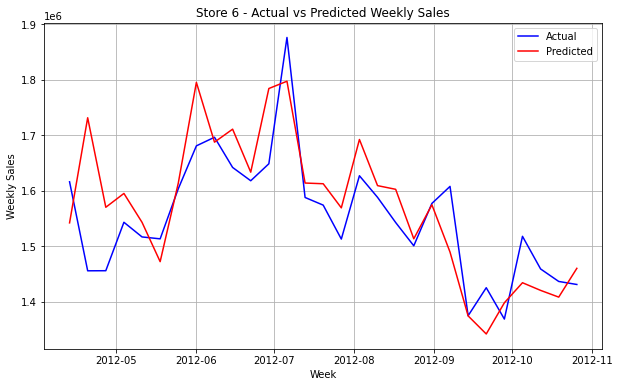

Store 6 results:
                Actual     Predicted     Difference
2012-04-13  1616394.45  1.542423e+06   73971.300373
2012-04-20  1456073.24  1.731746e+06 -275672.912636
2012-04-27  1456221.10  1.570505e+06 -114283.828855
2012-05-04  1543461.12  1.595416e+06  -51954.862863
2012-05-11  1517075.67  1.543381e+06  -26305.270104
2012-05-18  1513635.64  1.472543e+06   41092.952361
2012-05-25  1603793.42  1.613850e+06  -10056.396227
2012-06-01  1681121.38  1.795439e+06 -114317.352317
2012-06-08  1696619.52  1.687798e+06    8821.244169
2012-06-15  1642247.48  1.711176e+06  -68928.693707
2012-06-22  1618272.25  1.633728e+06  -15455.947355
2012-06-29  1648863.46  1.784419e+06 -135555.483838
2012-07-06  1876359.39  1.797513e+06   78846.129349
2012-07-13  1588142.26  1.614150e+06  -26008.156492
2012-07-20  1574361.97  1.612868e+06  -38505.646024
2012-07-27  1513229.16  1.569452e+06  -56222.717684
2012-08-03  1627274.93  1.692595e+06  -65320.452988
2012-08-10  1588380.73  1.609477e+06  -21096.15

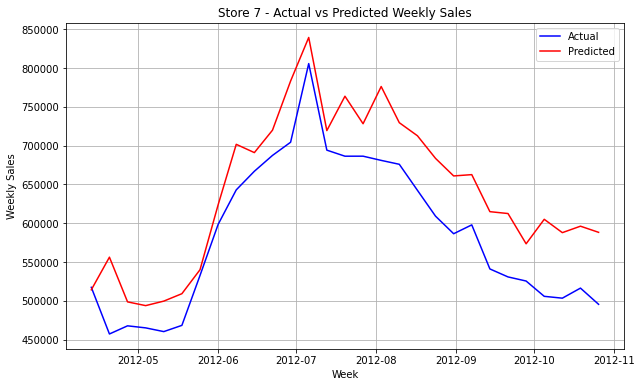

Store 7 results:
               Actual      Predicted    Difference
2012-04-13  517420.23  514254.347843   3165.882157
2012-04-20  457340.06  556264.915307 -98924.855307
2012-04-27  467827.75  498681.095497 -30853.345497
2012-05-04  465198.89  493863.629647 -28664.739647
2012-05-11  460397.41  499667.154488 -39269.744488
2012-05-18  468428.30  509229.567814 -40801.267814
2012-05-25  532739.77  540130.837719  -7391.067719
2012-06-01  598495.02  623735.580135 -25240.560135
2012-06-08  642963.75  701635.448560 -58671.698560
2012-06-15  666942.02  690973.770718 -24031.750718
2012-06-22  687344.68  719856.008797 -32511.328797
2012-06-29  704335.41  783180.447622 -78845.037622
2012-07-06  805642.61  839298.364678 -33655.754678
2012-07-13  694150.89  719317.287420 -25166.397420
2012-07-20  686345.69  763616.694620 -77271.004620
2012-07-27  686365.40  728153.504544 -41788.104544
2012-08-03  680954.81  776104.393258 -95149.583258
2012-08-10  675926.30  729503.290841 -53576.990841
2012-08-17  64

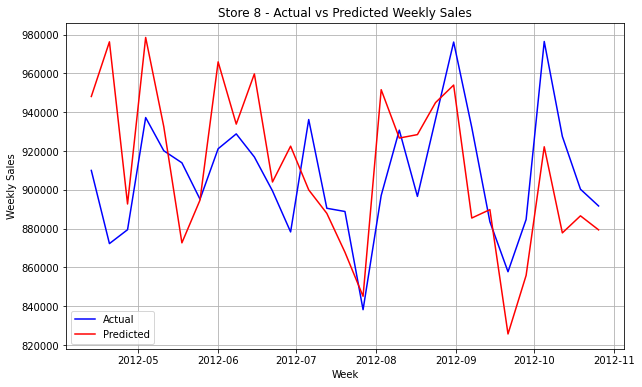

Store 8 results:
               Actual      Predicted     Difference
2012-04-13  909989.45  948091.868756  -38102.418756
2012-04-20  872288.46  976258.897908 -103970.437908
2012-04-27  879448.25  892692.204137  -13243.954137
2012-05-04  937232.09  978501.230375  -41269.140375
2012-05-11  920128.89  932555.964209  -12427.074209
2012-05-18  913922.01  872679.161511   41242.848489
2012-05-25  895157.44  894716.114071     441.325929
2012-06-01  921161.20  965929.487965  -44768.287965
2012-06-08  928820.00  933853.859876   -5033.859876
2012-06-15  916918.70  959734.508608  -42815.808608
2012-06-22  899449.65  904027.904406   -4578.254406
2012-06-29  878298.22  922490.448510  -44192.228510
2012-07-06  936205.50  899966.037857   36239.462143
2012-07-13  890488.01  887859.733393    2628.276607
2012-07-20  888834.07  867838.701026   20995.368974
2012-07-27  838227.52  845144.456409   -6916.936409
2012-08-03  897076.73  951589.723323  -54512.993323
2012-08-10  930745.69  926668.012157    4077.67

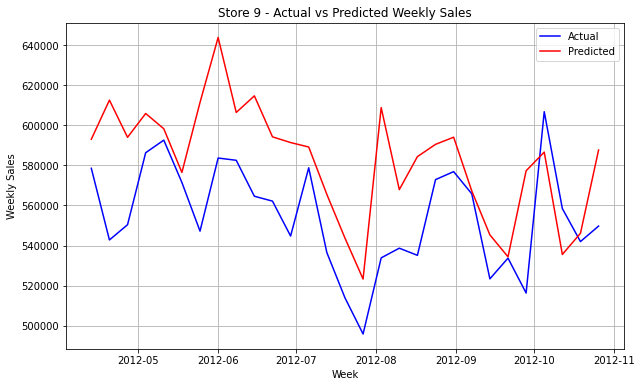

Store 9 results:
               Actual      Predicted    Difference
2012-04-13  578539.86  593013.988456 -14474.128456
2012-04-20  542819.03  612503.486077 -69684.456077
2012-04-27  550414.99  593976.020142 -43561.030142
2012-05-04  586289.08  605852.177910 -19563.097910
2012-05-11  592572.30  598245.989999  -5673.689999
2012-05-18  571463.93  576464.527571  -5000.597571
2012-05-25  547226.00  611366.494442 -64140.494442
2012-06-01  583648.59  643750.355578 -60101.765578
2012-06-08  582525.42  606365.712488 -23840.292488
2012-06-15  564606.10  614646.235635 -50040.135635
2012-06-22  562173.12  594220.512805 -32047.392805
2012-06-29  544770.70  591367.922777 -46597.222777
2012-07-06  578790.36  589141.783392 -10351.423392
2012-07-13  536537.64  565557.222039 -29019.582039
2012-07-20  513991.57  543760.975603 -29769.405603
2012-07-27  495951.00  523330.812695 -27379.812695
2012-08-03  533887.54  608799.383052 -74911.843052
2012-08-10  538713.47  567904.819930 -29191.349930
2012-08-17  53

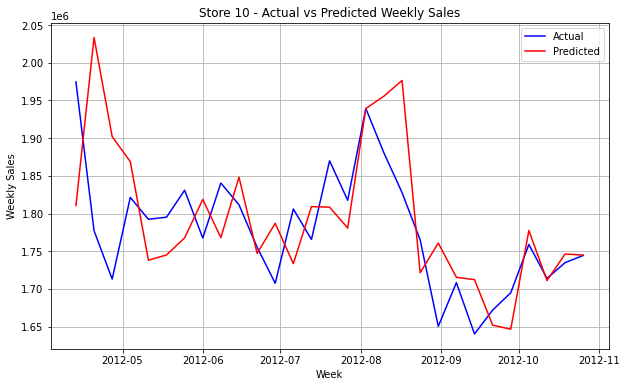

Store 10 results:
                Actual     Predicted     Difference
2012-04-13  1974687.51  1.810643e+06  164044.338966
2012-04-20  1777166.53  2.033622e+06 -256455.517352
2012-04-27  1712987.56  1.902101e+06 -189113.108596
2012-05-04  1821364.42  1.868854e+06  -47489.925553
2012-05-11  1792345.30  1.738050e+06   54295.408665
2012-05-18  1795152.73  1.744998e+06   50154.360597
2012-05-25  1830939.10  1.767765e+06   63174.057480
2012-06-01  1767471.48  1.818634e+06  -51162.811824
2012-06-08  1840491.41  1.768073e+06   72418.721235
2012-06-15  1811562.88  1.848236e+06  -36673.158170
2012-06-22  1755334.18  1.747095e+06    8238.860666
2012-06-29  1707481.90  1.787018e+06  -79536.324700
2012-07-06  1805999.79  1.733504e+06   72495.871987
2012-07-13  1765571.91  1.809152e+06  -43580.260840
2012-07-20  1869967.03  1.808439e+06   61528.117845
2012-07-27  1817603.66  1.780761e+06   36842.327685
2012-08-03  1939440.09  1.939245e+06     195.198349
2012-08-10  1880436.94  1.955753e+06  -75316.5

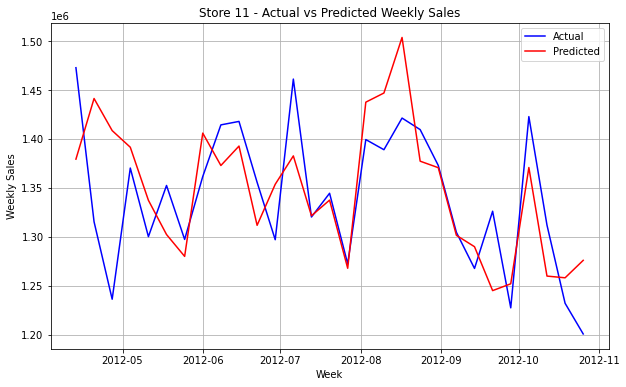

Store 11 results:
                Actual     Predicted     Difference
2012-04-13  1472752.01  1.379350e+06   93402.039924
2012-04-20  1315356.99  1.441289e+06 -125932.073163
2012-04-27  1236238.29  1.408494e+06 -172255.465928
2012-05-04  1370251.22  1.391493e+06  -21242.275968
2012-05-11  1300147.07  1.337314e+06  -37166.470756
2012-05-18  1352442.31  1.302332e+06   50110.542784
2012-05-25  1297335.87  1.279993e+06   17343.223450
2012-06-01  1361595.33  1.405924e+06  -44329.151020
2012-06-08  1414343.53  1.372837e+06   41506.778068
2012-06-15  1417875.42  1.392686e+06   25189.205566
2012-06-22  1355680.30  1.311738e+06   43942.078966
2012-06-29  1297028.60  1.353663e+06  -56634.482766
2012-07-06  1461129.94  1.382649e+06   78481.288804
2012-07-13  1320239.51  1.321498e+06   -1258.228844
2012-07-20  1344483.81  1.337492e+06    6991.342491
2012-07-27  1272395.02  1.267856e+06    4538.892669
2012-08-03  1399341.07  1.437546e+06  -38204.892990
2012-08-10  1388973.65  1.446904e+06  -57930.0

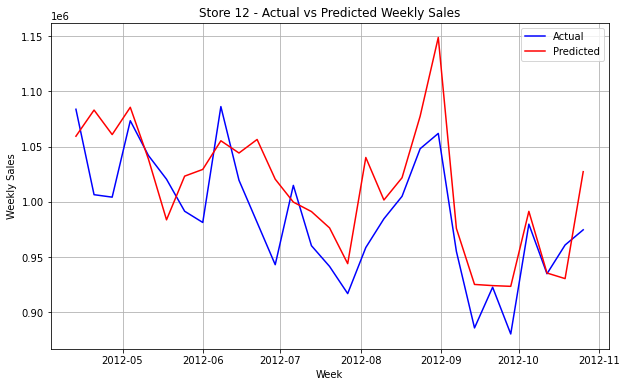

Store 12 results:
                Actual     Predicted    Difference
2012-04-13  1083811.19  1.059413e+06  24398.030637
2012-04-20  1006486.96  1.083080e+06 -76592.783625
2012-04-27  1004252.38  1.060906e+06 -56653.789825
2012-05-04  1073433.69  1.085583e+06 -12149.694130
2012-05-11  1041995.22  1.038816e+06   3179.053079
2012-05-18  1020486.05  9.837229e+05  36763.160739
2012-05-25   991514.21  1.023274e+06 -31760.083680
2012-06-01   981345.20  1.029352e+06 -48007.105012
2012-06-08  1086231.47  1.055286e+06  30945.768203
2012-06-15  1019555.51  1.044218e+06 -24662.157318
2012-06-22   981386.25  1.056464e+06 -75077.991218
2012-06-29   943124.74  1.020512e+06 -77387.599229
2012-07-06  1014898.78  9.997800e+05  15118.744874
2012-07-13   960312.75  9.912053e+05 -30892.550760
2012-07-20   941550.34  9.764050e+05 -34854.680278
2012-07-27   916967.92  9.440610e+05 -27093.063807
2012-08-03   958667.23  1.040159e+06 -81491.988142
2012-08-10   984689.90  1.001669e+06 -16978.659432
2012-08-17  1

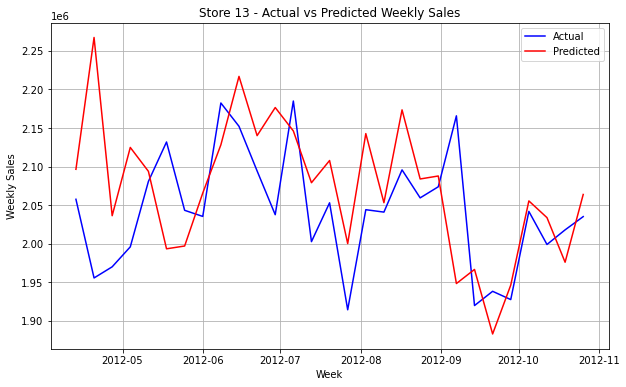

Store 13 results:
                Actual     Predicted     Difference
2012-04-13  2057637.86  2.096489e+06  -38851.578314
2012-04-20  1955689.12  2.267356e+06 -311667.379441
2012-04-27  1970121.65  2.036355e+06  -66233.300971
2012-05-04  1995994.51  2.124838e+06 -128843.545300
2012-05-11  2080764.17  2.093878e+06  -13113.682952
2012-05-18  2131900.55  1.993460e+06  138440.336509
2012-05-25  2043349.41  1.997093e+06   46255.910678
2012-06-01  2035431.39  2.065692e+06  -30260.911643
2012-06-08  2182437.90  2.128204e+06   54233.759774
2012-06-15  2152229.11  2.216903e+06  -64674.239127
2012-06-22  2094373.00  2.140123e+06  -45750.474023
2012-06-29  2037663.71  2.176549e+06 -138885.775847
2012-07-06  2184980.35  2.146212e+06   38768.658745
2012-07-13  2002750.99  2.079092e+06  -76341.033419
2012-07-20  2053089.32  2.107881e+06  -54791.421492
2012-07-27  1914430.53  2.000216e+06  -85785.900079
2012-08-03  2044148.23  2.142771e+06  -98622.348288
2012-08-10  2041019.92  2.053215e+06  -12195.0

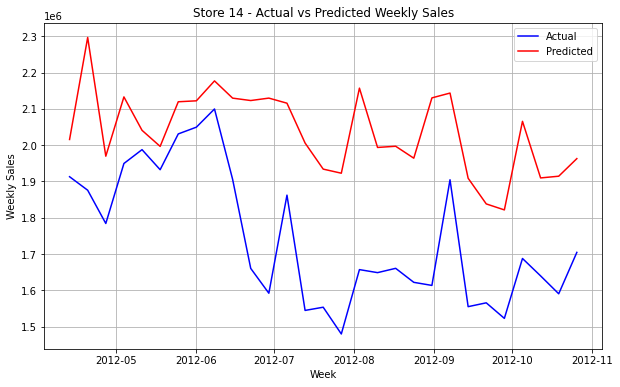

Store 14 results:
                Actual     Predicted     Difference
2012-04-13  1912909.69  2.015518e+06 -102608.376479
2012-04-20  1875686.44  2.296694e+06 -421007.556949
2012-04-27  1784029.95  1.969492e+06 -185461.882601
2012-05-04  1949354.29  2.132874e+06 -183520.082619
2012-05-11  1987531.05  2.040772e+06  -53240.820585
2012-05-18  1932233.17  1.996506e+06  -64272.861827
2012-05-25  2030869.61  2.119496e+06  -88626.578139
2012-06-01  2049485.49  2.122097e+06  -72611.690167
2012-06-08  2099615.88  2.176985e+06  -77368.820070
2012-06-15  1905733.68  2.129497e+06 -223763.119492
2012-06-22  1660228.88  2.122881e+06 -462651.637194
2012-06-29  1591835.02  2.129564e+06 -537729.116389
2012-07-06  1862128.95  2.115550e+06 -253420.569471
2012-07-13  1544422.35  2.005775e+06 -461352.809035
2012-07-20  1553250.16  1.933886e+06 -380635.790625
2012-07-27  1479514.66  1.922574e+06 -443058.933608
2012-08-03  1656886.46  2.157035e+06 -500148.946223
2012-08-10  1648570.03  1.993589e+06 -345018.9

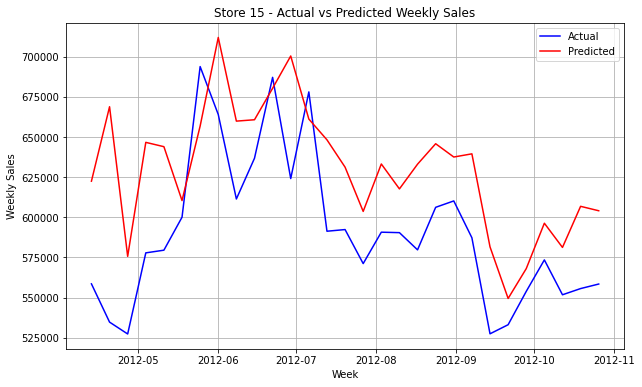

Store 15 results:
               Actual      Predicted     Difference
2012-04-13  558585.13  622482.426419  -63897.296419
2012-04-20  534780.57  668797.601723 -134017.031723
2012-04-27  527402.62  575697.751417  -48295.131417
2012-05-04  577868.38  646630.481489  -68762.101489
2012-05-11  579539.95  643940.844287  -64400.894287
2012-05-18  600050.98  610409.707017  -10358.727017
2012-05-25  693780.42  656772.389137   37008.030863
2012-06-01  663971.26  711896.961128  -47925.701128
2012-06-08  611390.67  659844.906534  -48454.236534
2012-06-15  636737.65  660698.015000  -23960.365000
2012-06-22  687085.60  680270.312991    6815.287009
2012-06-29  624099.48  700367.237361  -76267.757361
2012-07-06  678024.75  661122.080406   16902.669594
2012-07-13  591335.50  648206.874493  -56871.374493
2012-07-20  592369.22  631198.300431  -38829.080431
2012-07-27  571190.83  603663.163643  -32472.333643
2012-08-03  590739.62  633188.920872  -42449.300872
2012-08-10  590453.63  617675.559697  -27221.9

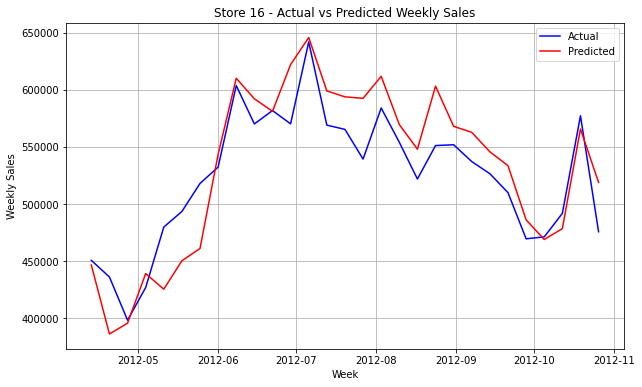

Store 16 results:
               Actual      Predicted    Difference
2012-04-13  450756.71  446690.053013   4066.656987
2012-04-20  436221.26  386379.624112  49841.635888
2012-04-27  398445.15  395820.141674   2625.008326
2012-05-04  426959.62  439188.184728 -12228.564728
2012-05-11  479855.00  425555.175600  54299.824400
2012-05-18  493506.47  450382.869340  43123.600660
2012-05-25  518045.09  461145.963896  56899.126104
2012-06-01  532311.93  543505.457039 -11193.527039
2012-06-08  603618.89  610001.479632  -6382.589632
2012-06-15  570045.79  592037.101535 -21991.311535
2012-06-22  581745.72  581080.264363    665.455637
2012-06-29  570162.28  621963.356885 -51801.076885
2012-07-06  641763.53  645674.957729  -3911.427729
2012-07-13  569005.06  598906.846235 -29901.786235
2012-07-20  565297.54  593747.711678 -28450.171678
2012-07-27  539337.87  592447.684734 -53109.814734
2012-08-03  584000.71  611700.164764 -27699.454764
2012-08-10  554036.84  569530.327146 -15493.487146
2012-08-17  5

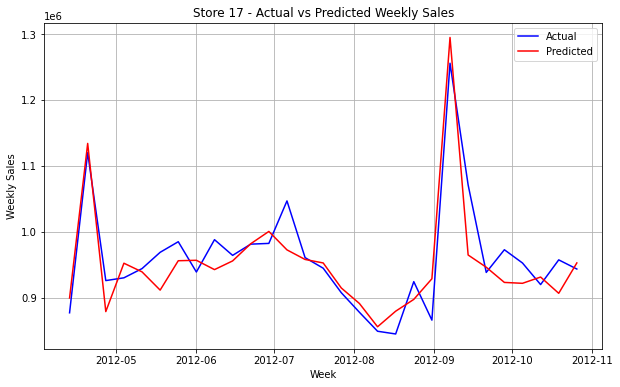

Store 17 results:
                Actual     Predicted     Difference
2012-04-13   877055.32  8.995346e+05  -22479.266726
2012-04-20  1119979.98  1.133982e+06  -14001.731538
2012-04-27   925916.65  8.788841e+05   47032.512414
2012-05-04   930121.14  9.522660e+05  -22144.859892
2012-05-11   944100.30  9.391373e+05    4963.030608
2012-05-18   968816.33  9.114713e+05   57344.990976
2012-05-25   984881.59  9.560489e+05   28832.646532
2012-06-01   938914.28  9.567154e+05  -17801.159221
2012-06-08   987990.24  9.425685e+05   45421.748954
2012-06-15   964169.67  9.557547e+05    8414.930409
2012-06-22   981210.57  9.818029e+05    -592.347244
2012-06-29   982322.24  1.000476e+06  -18153.479263
2012-07-06  1046782.52  9.725105e+05   74271.994518
2012-07-13   960746.04  9.579677e+05    2778.361220
2012-07-20   944698.70  9.526658e+05   -7967.131117
2012-07-27   907493.24  9.146804e+05   -7187.142266
2012-08-03   877813.33  8.911566e+05  -13343.309950
2012-08-10   849074.04  8.558586e+05   -6784.5

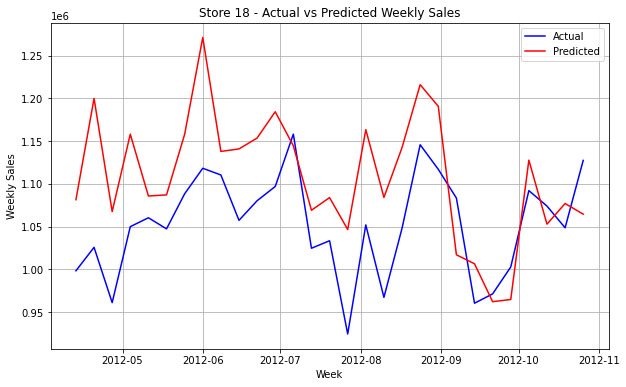

Store 18 results:
                Actual     Predicted     Difference
2012-04-13   998443.50  1.081543e+06  -83099.114898
2012-04-20  1025813.80  1.200003e+06 -174188.786408
2012-04-27   961186.23  1.067649e+06 -106463.095433
2012-05-04  1050027.89  1.158210e+06 -108181.655066
2012-05-11  1060433.10  1.085856e+06  -25422.403207
2012-05-18  1047444.59  1.087199e+06  -39754.895134
2012-05-25  1088446.58  1.157988e+06  -69541.543367
2012-06-01  1118313.70  1.271307e+06 -152993.364952
2012-06-08  1110479.94  1.138031e+06  -27551.364113
2012-06-15  1057425.83  1.140958e+06  -83532.432361
2012-06-22  1080357.89  1.153663e+06  -73304.702237
2012-06-29  1097006.30  1.184451e+06  -87444.853241
2012-07-06  1158247.31  1.144601e+06   13645.868717
2012-07-13  1024784.92  1.069215e+06  -44429.950907
2012-07-20  1033543.56  1.084020e+06  -50475.990649
2012-07-27   924506.26  1.046701e+06 -122194.277368
2012-08-03  1052066.58  1.163523e+06 -111456.823073
2012-08-10   967304.07  1.084201e+06 -116896.6

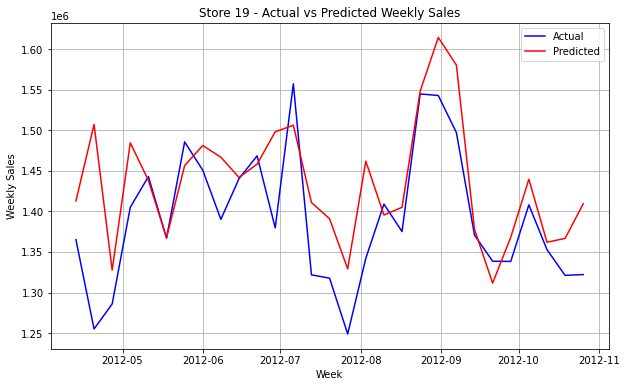

Store 19 results:
                Actual     Predicted     Difference
2012-04-13  1365098.46  1.412814e+06  -47715.117162
2012-04-20  1255087.26  1.507055e+06 -251968.078008
2012-04-27  1285897.24  1.327603e+06  -41705.677483
2012-05-04  1405007.44  1.484422e+06  -79414.230970
2012-05-11  1442873.22  1.438122e+06    4751.205216
2012-05-18  1366937.10  1.367458e+06    -520.676741
2012-05-25  1485540.28  1.456345e+06   29195.373051
2012-06-01  1450733.29  1.481103e+06  -30369.954652
2012-06-08  1390122.11  1.466684e+06  -76561.494079
2012-06-15  1440263.15  1.441702e+06   -1439.294197
2012-06-22  1468350.36  1.458210e+06   10140.332688
2012-06-29  1379652.65  1.498018e+06 -118365.151131
2012-07-06  1557120.44  1.506082e+06   51038.034881
2012-07-13  1321741.35  1.410862e+06  -89120.343922
2012-07-20  1317672.92  1.390833e+06  -73160.435051
2012-07-27  1248915.43  1.329099e+06  -80183.754226
2012-08-03  1342123.78  1.461875e+06 -119750.970759
2012-08-10  1408907.89  1.395501e+06   13406.4

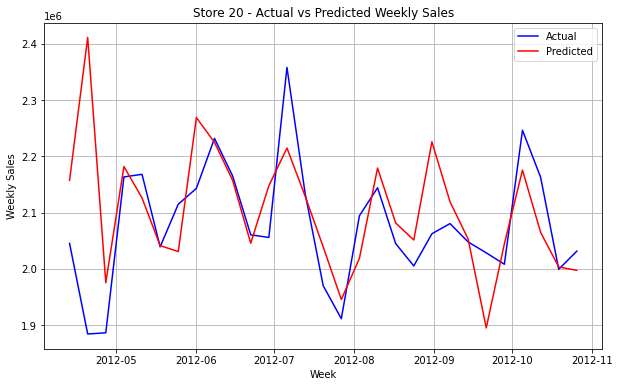

Store 20 results:
                Actual     Predicted     Difference
2012-04-13  2045396.06  2.157445e+06 -112049.358163
2012-04-20  1884427.84  2.411272e+06 -526844.522929
2012-04-27  1886503.93  1.975559e+06  -89054.880791
2012-05-04  2163510.89  2.181981e+06  -18470.295559
2012-05-11  2168097.11  2.126136e+06   41961.057431
2012-05-18  2039222.26  2.041384e+06   -2161.525025
2012-05-25  2114989.00  2.030886e+06   84102.847837
2012-06-01  2143126.59  2.268906e+06 -125779.873086
2012-06-08  2231962.13  2.224824e+06    7138.469500
2012-06-15  2165160.29  2.157482e+06    7678.773784
2012-06-22  2060588.69  2.045689e+06   14899.379211
2012-06-29  2055952.61  2.147726e+06  -91772.967169
2012-07-06  2358055.30  2.214826e+06  143229.355201
2012-07-13  2134680.12  2.129484e+06    5196.079269
2012-07-20  1970170.29  2.039181e+06  -69010.670481
2012-07-27  1911559.10  1.945670e+06  -34110.951607
2012-08-03  2094515.71  2.018918e+06   75597.670622
2012-08-10  2144245.39  2.179231e+06  -34985.9

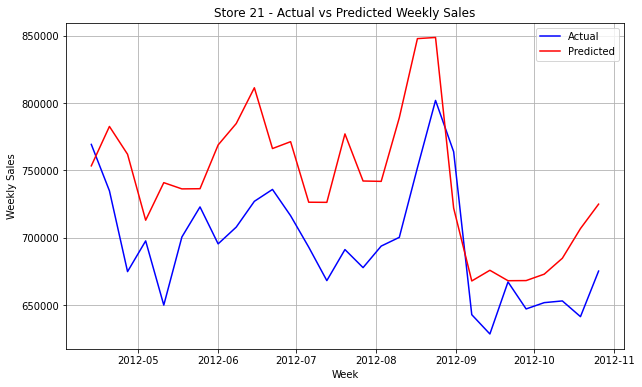

Store 21 results:
               Actual      Predicted    Difference
2012-04-13  769319.04  753401.915868  15917.124132
2012-04-20  734858.91  782674.261567 -47815.351567
2012-04-27  674829.58  762007.557116 -87177.977116
2012-05-04  697645.32  713010.706037 -15365.386037
2012-05-11  649945.54  740911.554732 -90966.014732
2012-05-18  700554.16  736274.331539 -35720.171539
2012-05-25  722891.24  736409.914831 -13518.674831
2012-06-01  695439.83  768917.079956 -73477.249956
2012-06-08  707895.72  784837.301399 -76941.581399
2012-06-15  727049.04  811409.163669 -84360.123669
2012-06-22  735870.00  766249.281736 -30379.281736
2012-06-29  716341.39  771340.777765 -54999.387765
2012-07-06  693013.59  726376.263274 -33362.673274
2012-07-13  668132.36  726283.992241 -58151.632241
2012-07-20  691200.33  777127.148531 -85926.818531
2012-07-27  677789.14  742140.937472 -64351.797472
2012-08-03  693785.85  741866.636226 -48080.786226
2012-08-10  700272.01  789165.918792 -88893.908792
2012-08-17  7

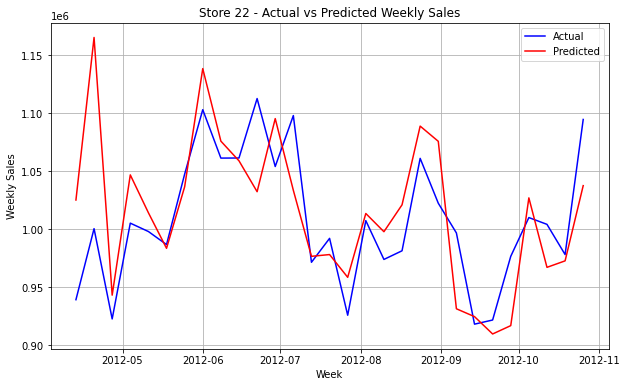

Store 22 results:
                Actual     Predicted     Difference
2012-04-13   939118.24  1.025011e+06  -85892.877736
2012-04-20  1000342.87  1.165084e+06 -164740.642422
2012-04-27   922539.94  9.430268e+05  -20486.860909
2012-05-04  1005083.31  1.046670e+06  -41586.942361
2012-05-11   997868.63  1.014037e+06  -16167.914877
2012-05-18   986612.02  9.833904e+05    3221.573254
2012-05-25  1047297.38  1.036394e+06   10903.468044
2012-06-01  1102857.37  1.138243e+06  -35385.229357
2012-06-08  1061134.37  1.075751e+06  -14616.797028
2012-06-15  1061219.19  1.058792e+06    2427.427501
2012-06-22  1112449.30  1.032182e+06   80267.132814
2012-06-29  1053881.78  1.095167e+06  -41285.141253
2012-07-06  1097786.14  1.033379e+06   64407.570022
2012-07-13   971361.38  9.765043e+05   -5142.967553
2012-07-20   991969.37  9.780178e+05   13951.598422
2012-07-27   925731.21  9.584069e+05  -32675.665796
2012-08-03  1007257.83  1.013406e+06   -6148.075331
2012-08-10   973812.79  9.977116e+05  -23898.7

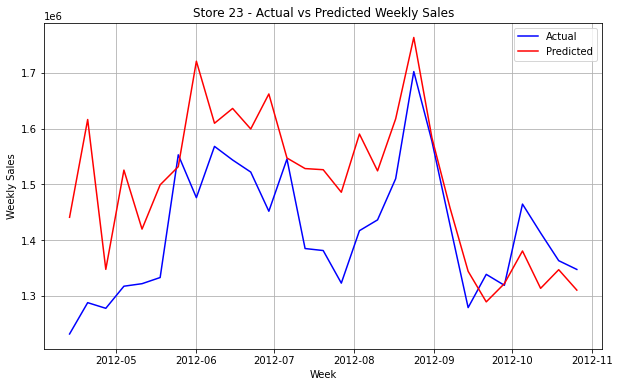

Store 23 results:
                Actual     Predicted     Difference
2012-04-13  1231752.54  1.440955e+06 -209202.124260
2012-04-20  1287899.41  1.616239e+06 -328339.117505
2012-04-27  1277758.76  1.347604e+06  -69844.758457
2012-05-04  1317379.68  1.525539e+06 -208159.635130
2012-05-11  1321914.34  1.419771e+06  -97857.029581
2012-05-18  1332952.47  1.499139e+06 -166186.572310
2012-05-25  1552934.64  1.531677e+06   21257.259634
2012-06-01  1476144.34  1.720777e+06 -244632.636088
2012-06-08  1568048.54  1.609544e+06  -41495.865943
2012-06-15  1543667.68  1.636089e+06  -92421.104612
2012-06-22  1522042.57  1.599289e+06  -77246.372741
2012-06-29  1451782.16  1.662060e+06 -210277.378010
2012-07-06  1545370.16  1.547228e+06   -1858.018839
2012-07-13  1384921.63  1.528293e+06 -143371.011955
2012-07-20  1381339.23  1.526251e+06 -144912.144391
2012-07-27  1322932.36  1.485826e+06 -162893.442688
2012-08-03  1416926.31  1.590187e+06 -173260.829137
2012-08-10  1436311.76  1.524174e+06  -87862.6

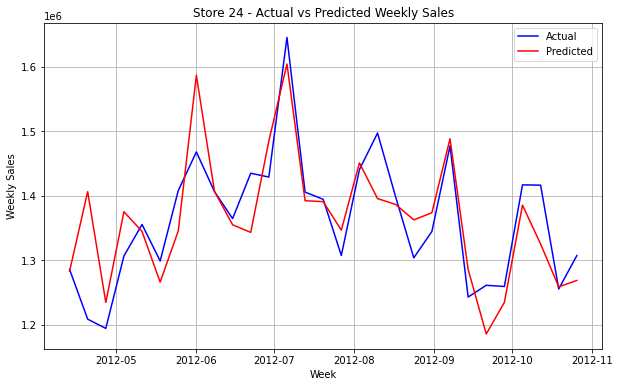

Store 24 results:
                Actual     Predicted     Difference
2012-04-13  1285783.87  1.282844e+06    2939.910672
2012-04-20  1208654.40  1.406206e+06 -197551.813387
2012-04-27  1194334.65  1.234513e+06  -40177.986514
2012-05-04  1306551.71  1.375052e+06  -68499.897294
2012-05-11  1355391.79  1.344613e+06   10779.120768
2012-05-18  1298809.80  1.266067e+06   32742.470921
2012-05-25  1407897.57  1.345414e+06   62483.383526
2012-06-01  1467722.19  1.586463e+06 -118740.620106
2012-06-08  1406313.13  1.406611e+06    -298.063133
2012-06-15  1364445.98  1.354863e+06    9582.578354
2012-06-22  1434709.63  1.343073e+06   91636.543658
2012-06-29  1428869.90  1.484851e+06  -55981.390204
2012-07-06  1645097.75  1.603973e+06   41124.411104
2012-07-13  1405475.78  1.392152e+06   13324.258831
2012-07-20  1394299.00  1.390698e+06    3600.794290
2012-07-27  1307339.14  1.346581e+06  -39242.103165
2012-08-03  1440374.13  1.450792e+06  -10417.909377
2012-08-10  1497054.81  1.395424e+06  101630.9

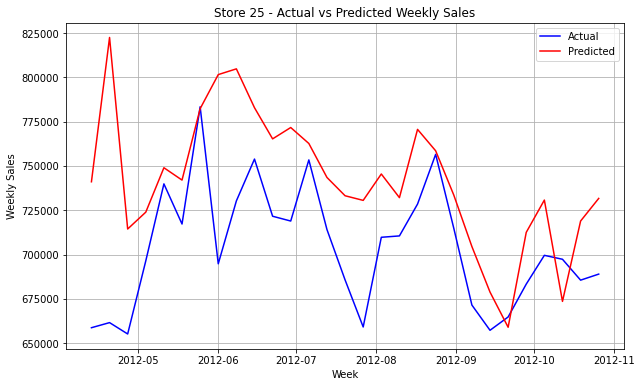

Store 25 results:
               Actual      Predicted     Difference
2012-04-13  658691.56  741049.900982  -82358.340982
2012-04-20  661566.48  822491.192132 -160924.712132
2012-04-27  655157.32  714403.310515  -59245.990515
2012-05-04  696421.72  723912.308499  -27490.588499
2012-05-11  739866.16  748973.359344   -9107.199344
2012-05-18  717207.19  742005.434617  -24798.244617
2012-05-25  783371.02  782303.144253    1067.875747
2012-06-01  694765.95  801535.699393 -106769.749393
2012-06-08  730254.19  804774.994268  -74520.804268
2012-06-15  753860.89  782843.289200  -28982.399200
2012-06-22  721601.90  765266.093699  -43664.193699
2012-06-29  718890.81  771668.794932  -52777.984932
2012-07-06  753385.55  762659.468899   -9273.918899
2012-07-13  714093.95  743489.170023  -29395.220023
2012-07-20  685676.58  733164.516239  -47487.936239
2012-07-27  659109.53  730551.802385  -71442.272385
2012-08-03  709724.60  745440.433132  -35715.833132
2012-08-10  710496.97  732097.719293  -21600.7

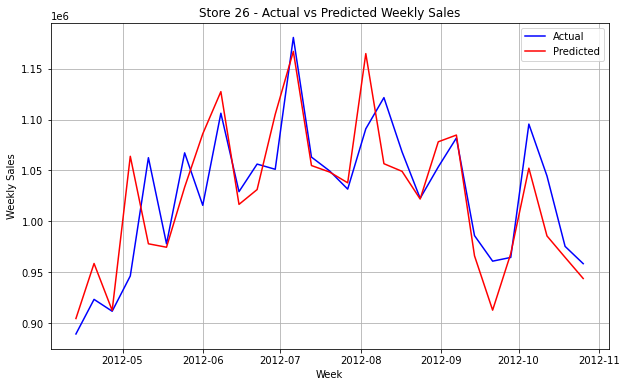

Store 26 results:
                Actual     Predicted     Difference
2012-04-13   889670.29  9.048305e+05  -15160.234242
2012-04-20   923600.02  9.588092e+05  -35209.193640
2012-04-27   911969.00  9.127394e+05    -770.350404
2012-05-04   946573.29  1.063926e+06 -117352.479374
2012-05-11  1062548.73  9.781126e+05   84436.130959
2012-05-18   978082.84  9.747462e+05    3336.683673
2012-05-25  1067310.74  1.033644e+06   33666.383513
2012-06-01  1015853.03  1.085940e+06  -70087.224301
2012-06-08  1106176.83  1.127352e+06  -21175.215021
2012-06-15  1029248.22  1.016766e+06   12482.074796
2012-06-22  1056282.91  1.031289e+06   24993.496360
2012-06-29  1051190.44  1.105058e+06  -53867.424149
2012-07-06  1180470.80  1.166787e+06   13683.754134
2012-07-13  1063149.78  1.054870e+06    8279.837136
2012-07-20  1049625.90  1.048502e+06    1124.060889
2012-07-27  1031745.14  1.037935e+06   -6190.143298
2012-08-03  1090915.09  1.164650e+06  -73735.278332
2012-08-10  1121476.51  1.056659e+06   64817.3

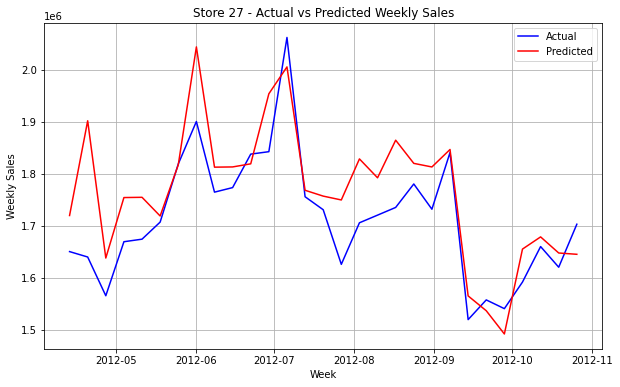

Store 27 results:
                Actual     Predicted     Difference
2012-04-13  1650405.21  1.719796e+06  -69390.590518
2012-04-20  1639999.47  1.901990e+06 -261990.906711
2012-04-27  1565498.84  1.638017e+06  -72518.367559
2012-05-04  1669388.45  1.754329e+06  -84940.776270
2012-05-11  1674306.31  1.754819e+06  -80513.185102
2012-05-18  1707158.82  1.718883e+06  -11723.802107
2012-05-25  1818906.73  1.817197e+06    1709.588185
2012-06-01  1900638.60  2.044084e+06 -143445.498461
2012-06-08  1764756.31  1.812787e+06  -48030.665755
2012-06-15  1773500.56  1.813229e+06  -39728.931524
2012-06-22  1837884.79  1.819201e+06   18684.150986
2012-06-29  1842555.32  1.953911e+06 -111355.937384
2012-07-06  2062224.92  2.005598e+06   56626.624174
2012-07-13  1755889.53  1.768322e+06  -12432.548607
2012-07-20  1730913.66  1.757117e+06  -26202.901753
2012-07-27  1625883.71  1.749715e+06 -123831.514909
2012-08-03  1705810.84  1.828650e+06 -122838.886682
2012-08-10  1720537.26  1.792334e+06  -71796.9

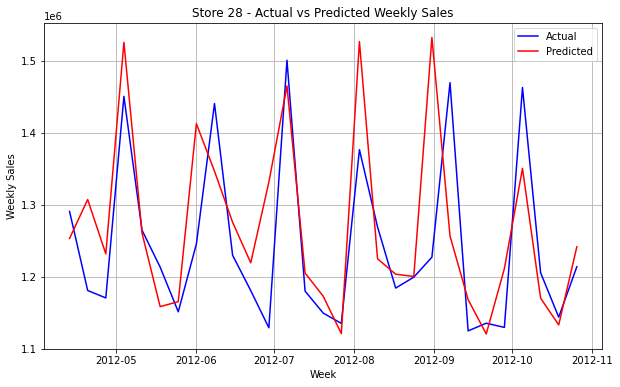

Store 28 results:
                Actual     Predicted     Difference
2012-04-13  1290684.95  1.253144e+06   37540.897048
2012-04-20  1180797.20  1.307254e+06 -126456.716210
2012-04-27  1170456.16  1.231734e+06  -61277.774948
2012-05-04  1450628.85  1.525686e+06  -75057.180323
2012-05-11  1264575.18  1.260612e+06    3963.444651
2012-05-18  1213310.45  1.158350e+06   54959.976365
2012-05-25  1151214.41  1.165320e+06  -14105.097087
2012-06-01  1245480.95  1.412705e+06 -167224.185531
2012-06-08  1440687.69  1.346580e+06   94107.247674
2012-06-15  1229760.97  1.275612e+06  -45851.253057
2012-06-22  1180671.55  1.219298e+06  -38626.613515
2012-06-29  1129031.98  1.331362e+06 -202330.093801
2012-07-06  1500863.54  1.465101e+06   35762.598083
2012-07-13  1179915.04  1.205086e+06  -25170.844095
2012-07-20  1149427.48  1.172827e+06  -23399.352420
2012-07-27  1135035.09  1.120879e+06   14155.802995
2012-08-03  1376520.10  1.526821e+06 -150300.665503
2012-08-10  1269113.41  1.224858e+06   44255.0

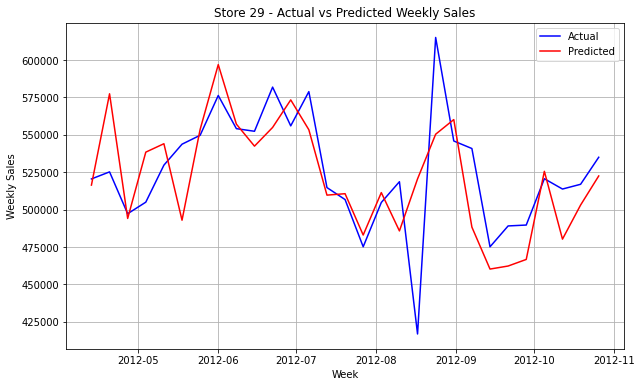

Store 29 results:
               Actual      Predicted     Difference
2012-04-13  520493.83  516372.275201    4121.554799
2012-04-20  525200.59  577386.909973  -52186.319973
2012-04-27  497250.22  494095.626080    3154.593920
2012-05-04  504963.84  538393.174070  -33429.334070
2012-05-11  529707.87  544019.064814  -14311.194814
2012-05-18  543706.04  492911.928701   50794.111299
2012-05-25  549665.67  553595.173094   -3929.503094
2012-06-01  576252.35  596886.545149  -20634.195149
2012-06-08  554093.15  557115.288060   -3022.138060
2012-06-15  552338.76  542402.029931    9936.730069
2012-06-22  581854.50  554902.968705   26951.531295
2012-06-29  555954.13  573312.521946  -17358.391946
2012-07-06  578832.41  553372.922960   25459.487040
2012-07-13  514709.76  509666.231502    5043.528498
2012-07-20  506705.36  510621.998876   -3916.638876
2012-07-27  475158.24  483006.344551   -7848.104551
2012-08-03  504754.74  511357.789246   -6603.049246
2012-08-10  518628.42  485750.280522   32878.1

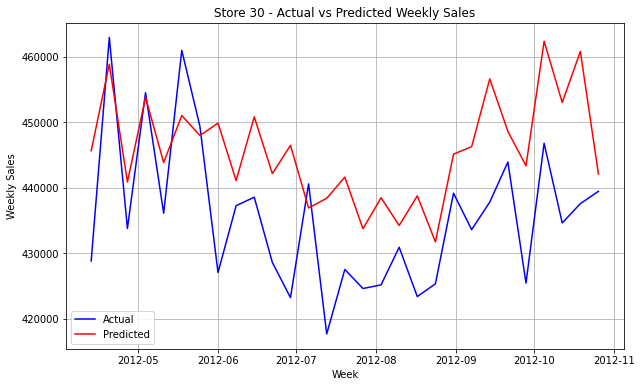

Store 30 results:
               Actual      Predicted    Difference
2012-04-13  428784.70  445606.213993 -16821.513993
2012-04-20  462909.41  458824.111517   4085.298483
2012-04-27  433744.83  440846.643635  -7101.813635
2012-05-04  454477.54  453774.150893    703.389107
2012-05-11  436070.45  443806.782438  -7736.332438
2012-05-18  460945.14  450997.272260   9947.867740
2012-05-25  449355.91  447935.148372   1420.761628
2012-06-01  427021.18  449835.716198 -22814.536198
2012-06-08  437222.94  441069.939097  -3846.999097
2012-06-15  438523.24  450798.234644 -12274.994644
2012-06-22  428554.63  442125.927016 -13571.297016
2012-06-29  423192.40  446434.976538 -23242.576538
2012-07-06  440553.42  436875.802111   3677.617889
2012-07-13  417640.34  438358.841780 -20718.501780
2012-07-20  427491.04  441590.482395 -14099.442395
2012-07-27  424581.17  433706.492149  -9125.322149
2012-08-03  425136.55  438437.573791 -13301.023791
2012-08-10  430878.28  434202.351286  -3324.071286
2012-08-17  4

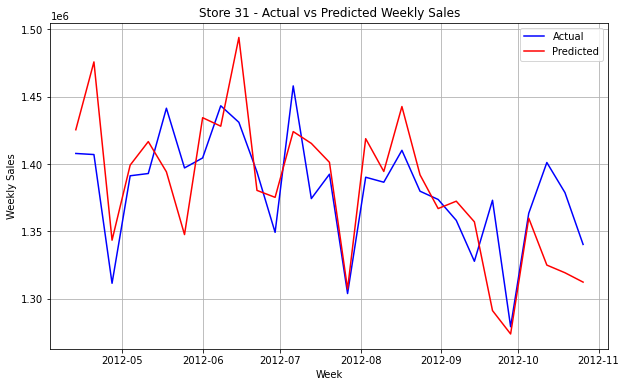

Store 31 results:
                Actual     Predicted    Difference
2012-04-13  1407842.91  1.425474e+06 -17631.147829
2012-04-20  1407036.59  1.475895e+06 -68858.225919
2012-04-27  1311352.25  1.343382e+06 -32029.538312
2012-05-04  1391257.28  1.399172e+06  -7915.166942
2012-05-11  1392938.06  1.416658e+06 -23719.646529
2012-05-18  1441473.82  1.394201e+06  47272.733939
2012-05-25  1397094.26  1.347560e+06  49533.956012
2012-06-01  1404516.29  1.434432e+06 -29915.658391
2012-06-08  1443285.79  1.428116e+06  15169.778029
2012-06-15  1431003.43  1.494063e+06 -63059.448501
2012-06-22  1394065.76  1.380398e+06  13667.681099
2012-06-29  1349202.25  1.375225e+06 -26022.479771
2012-07-06  1458059.42  1.424104e+06  33955.002034
2012-07-13  1374301.34  1.415322e+06 -41020.683026
2012-07-20  1392395.20  1.401259e+06  -8863.424391
2012-07-27  1303732.36  1.307121e+06  -3388.939826
2012-08-03  1390174.63  1.418843e+06 -28668.776698
2012-08-10  1386472.59  1.394461e+06  -7988.180126
2012-08-17  1

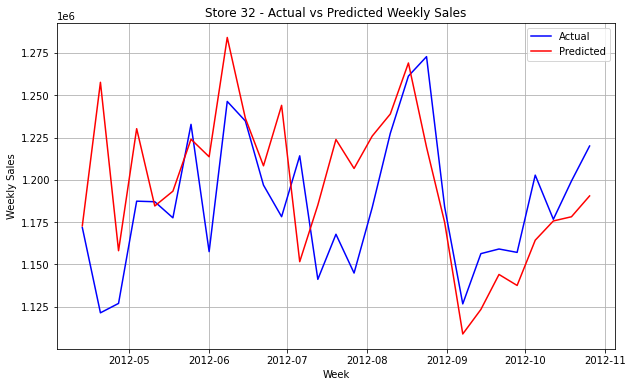

Store 32 results:
                Actual     Predicted     Difference
2012-04-13  1171834.47  1.172799e+06    -964.959628
2012-04-20  1121405.91  1.257633e+06 -136227.356449
2012-04-27  1126962.44  1.158106e+06  -31143.560870
2012-05-04  1187384.53  1.230222e+06  -42837.161148
2012-05-11  1187051.07  1.184538e+06    2513.127201
2012-05-18  1177539.71  1.193277e+06  -15737.742971
2012-05-25  1232784.22  1.223997e+06    8787.215134
2012-06-01  1157557.79  1.213624e+06  -56066.352264
2012-06-08  1246322.44  1.284130e+06  -37807.719237
2012-06-15  1234759.54  1.236392e+06   -1632.682605
2012-06-22  1196880.11  1.208282e+06  -11401.515123
2012-06-29  1178211.81  1.244014e+06  -65802.578846
2012-07-06  1214183.97  1.151613e+06   62570.724090
2012-07-13  1141184.66  1.185094e+06  -43909.752891
2012-07-20  1167829.33  1.223840e+06  -56010.428340
2012-07-27  1144901.52  1.206712e+06  -61810.457513
2012-08-03  1183571.35  1.225831e+06  -42259.728886
2012-08-10  1227469.20  1.238882e+06  -11412.6

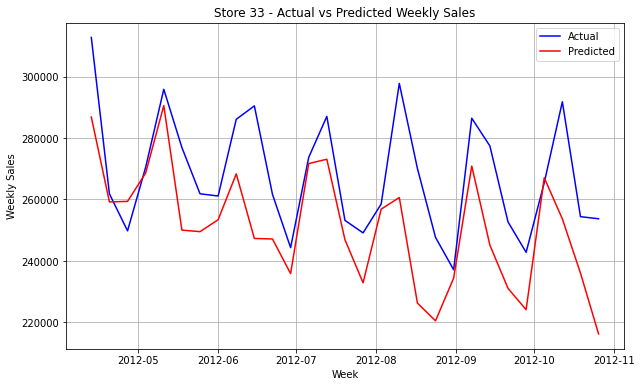

Store 33 results:
               Actual      Predicted    Difference
2012-04-13  312698.67  286808.505838  25890.164162
2012-04-20  261837.20  259208.634558   2628.565442
2012-04-27  249798.75  259386.318016  -9587.568016
2012-05-04  270497.51  268591.496244   1906.013756
2012-05-11  295841.84  290538.500808   5303.339192
2012-05-18  276899.95  250045.440085  26854.509915
2012-05-25  261851.74  249531.386606  12320.353394
2012-06-01  261131.09  253416.543621   7714.546379
2012-06-08  286082.76  268331.231428  17751.528572
2012-06-15  290444.31  247328.478879  43115.831121
2012-06-22  261666.29  247153.824926  14512.465074
2012-06-29  244338.31  235891.791706   8446.518294
2012-07-06  273690.37  271675.554834   2014.815166
2012-07-13  287033.64  273098.562097  13935.077903
2012-07-20  253205.89  246911.968299   6293.921701
2012-07-27  249134.32  232909.090082  16225.229918
2012-08-03  258533.12  256858.318358   1674.801642
2012-08-10  297753.49  260636.394922  37117.095078
2012-08-17  2

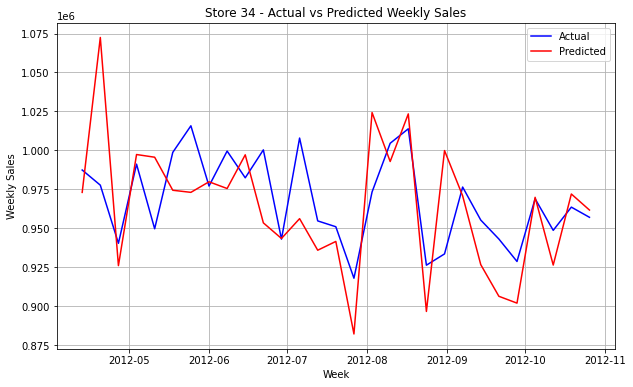

Store 34 results:
                Actual     Predicted    Difference
2012-04-13   987353.65  9.729808e+05  14372.823110
2012-04-20   977628.78  1.072456e+06 -94827.629544
2012-04-27   940299.87  9.259646e+05  14335.297500
2012-05-04   991104.40  9.972940e+05  -6189.641072
2012-05-11   949625.52  9.955722e+05 -45946.716207
2012-05-18   998672.85  9.743532e+05  24319.603941
2012-05-25  1015737.61  9.730086e+05  42729.057029
2012-06-01   977062.44  9.797876e+05  -2725.123576
2012-06-08   999511.29  9.754722e+05  24039.081614
2012-06-15   982345.51  9.971138e+05 -14768.250716
2012-06-22  1000285.10  9.534151e+05  46869.953263
2012-06-29   942970.63  9.433991e+05   -428.511254
2012-07-06  1007867.68  9.561235e+05  51744.137532
2012-07-13   954677.75  9.358509e+05  18826.876794
2012-07-20   950929.59  9.414918e+05   9437.751721
2012-07-27   917883.79  8.820773e+05  35806.447279
2012-08-03   973250.41  1.024251e+06 -51000.764991
2012-08-10  1004523.59  9.928057e+05  11717.910828
2012-08-17  1

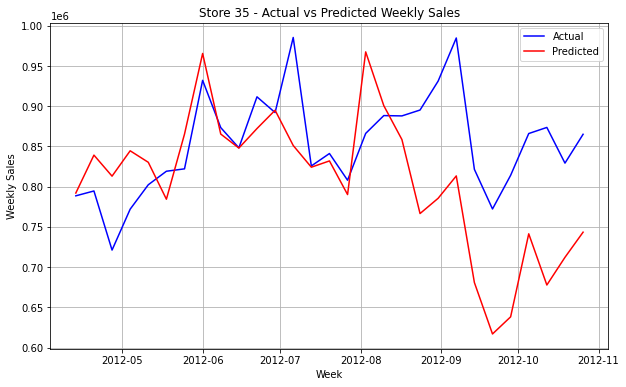

Store 35 results:
               Actual      Predicted     Difference
2012-04-13  788633.42  792083.446943   -3450.026943
2012-04-20  794660.24  839235.695228  -44575.455228
2012-04-27  721212.45  813092.258932  -91879.808932
2012-05-04  772036.60  844615.762774  -72579.162774
2012-05-11  802383.63  830312.935176  -27929.305176
2012-05-18  819196.68  784432.194281   34764.485719
2012-05-25  822167.17  865379.648194  -43212.478194
2012-06-01  932195.52  965587.425410  -33391.905410
2012-06-08  873415.01  865410.782081    8004.227919
2012-06-15  848289.41  848006.890516     282.519484
2012-06-22  911696.00  872262.437799   39433.562201
2012-06-29  892133.41  895019.351706   -2885.941706
2012-07-06  985479.64  851196.831563  134282.808437
2012-07-13  825763.48  824207.049229    1556.430771
2012-07-20  841224.74  832018.304413    9206.435587
2012-07-27  808030.15  790214.297127   17815.852873
2012-08-03  866216.36  967565.540092 -101349.180092
2012-08-10  888368.80  900688.669868  -12319.8

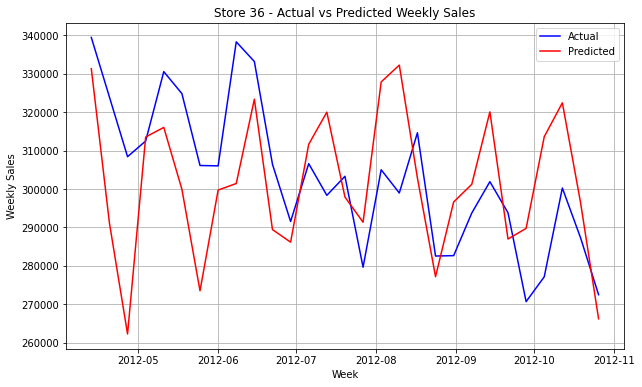

Store 36 results:
               Actual      Predicted    Difference
2012-04-13  339407.94  331291.534334   8116.405666
2012-04-20  323915.32  291138.393699  32776.926301
2012-04-27  308389.82  262267.775898  46122.044102
2012-05-04  312467.52  313505.475431  -1037.955431
2012-05-11  330518.34  316007.414256  14510.925744
2012-05-18  324801.13  299907.443782  24893.686218
2012-05-25  306098.17  273500.157596  32598.012404
2012-06-01  306005.53  299707.291709   6298.238291
2012-06-08  338273.38  301409.864139  36863.515861
2012-06-15  333146.88  323346.554699   9800.325301
2012-06-22  306411.01  289418.889755  16992.120245
2012-06-29  291530.43  286152.035127   5378.394873
2012-07-06  306578.89  311618.610422  -5039.720422
2012-07-13  298337.41  319982.193826 -21644.783826
2012-07-20  303289.55  297893.909527   5395.640473
2012-07-27  279643.43  291338.845862 -11695.415862
2012-08-03  304989.97  327843.677494 -22853.707494
2012-08-10  298947.51  332216.200166 -33268.690166
2012-08-17  3

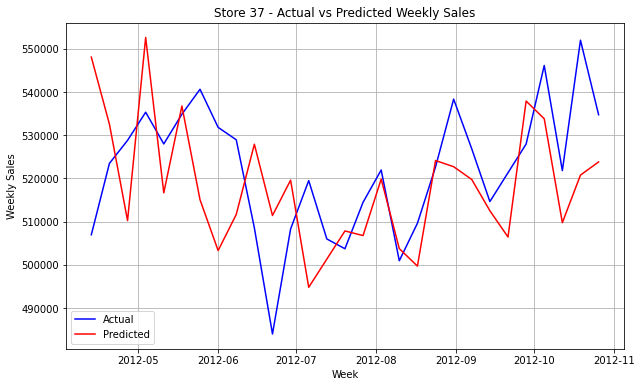

Store 37 results:
               Actual      Predicted    Difference
2012-04-13  506973.17  548063.875310 -41090.705310
2012-04-20  523483.19  532545.655594  -9062.465594
2012-04-27  528807.45  510257.657310  18549.792690
2012-05-04  535311.64  552604.371095 -17292.731095
2012-05-11  527983.04  516677.083481  11305.956519
2012-05-18  534847.96  536755.447943  -1907.487943
2012-05-25  540625.79  515081.315899  25544.474101
2012-06-01  531811.85  503323.464077  28488.385923
2012-06-08  528940.78  511671.748426  17269.031574
2012-06-15  508573.16  527907.984261 -19334.824261
2012-06-22  484032.75  511429.792105 -27397.042105
2012-06-29  508309.81  519602.558806 -11292.748806
2012-07-06  519498.32  494827.213668  24671.106332
2012-07-13  506005.47  501351.218309   4654.251691
2012-07-20  503744.56  507858.808653  -4114.248653
2012-07-27  514489.17  506793.995771   7695.174229
2012-08-03  521959.28  519857.361822   2101.918178
2012-08-10  500964.59  503769.731009  -2805.141009
2012-08-17  5

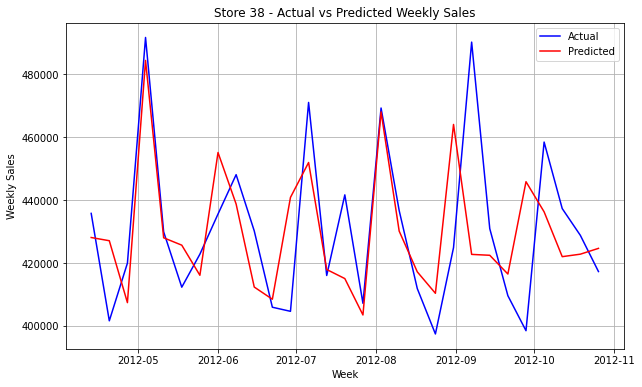

Store 38 results:
               Actual      Predicted    Difference
2012-04-13  435790.74  428114.844611   7675.895389
2012-04-20  401615.80  427093.031840 -25477.231840
2012-04-27  419964.77  407397.838512  12566.931488
2012-05-04  491755.69  484456.540348   7299.149652
2012-05-11  429914.60  428028.029426   1886.570574
2012-05-18  412314.71  425680.664371 -13365.954371
2012-05-25  422810.12  416102.099305   6708.020695
2012-06-01  435579.70  455156.751180 -19577.051180
2012-06-08  448110.25  438758.779453   9351.470547
2012-06-15  430222.07  412358.090177  17863.979823
2012-06-22  405938.35  408480.656958  -2542.306958
2012-06-29  404634.36  440877.126213 -36242.766213
2012-07-06  471086.22  451980.698970  19105.521030
2012-07-13  416036.75  417935.310181  -1898.560181
2012-07-20  441683.74  415053.448830  26630.291170
2012-07-27  407186.47  403475.570860   3710.899140
2012-08-03  469311.17  468089.672419   1221.497581
2012-08-10  436690.13  430151.981974   6538.148026
2012-08-17  4

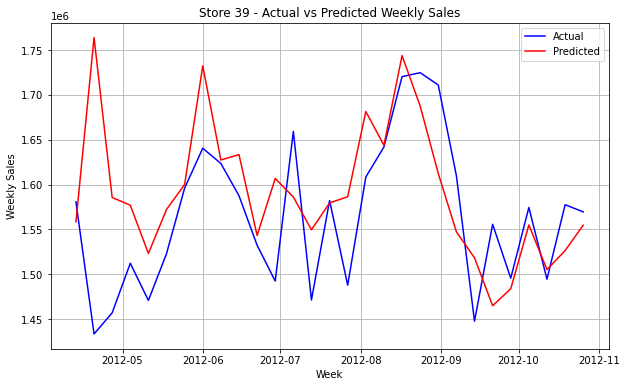

Store 39 results:
                Actual     Predicted     Difference
2012-04-13  1580732.73  1.558357e+06   22375.591255
2012-04-20  1433391.04  1.763932e+06 -330541.032870
2012-04-27  1456997.20  1.585532e+06 -128534.438986
2012-05-04  1512227.34  1.576949e+06  -64721.735675
2012-05-11  1470792.41  1.523157e+06  -52364.201323
2012-05-18  1522978.54  1.572225e+06  -49246.100630
2012-05-25  1596036.66  1.600126e+06   -4088.977921
2012-06-01  1640476.77  1.732250e+06  -91773.565489
2012-06-08  1623442.24  1.627325e+06   -3882.462489
2012-06-15  1587499.82  1.633335e+06  -45835.321862
2012-06-22  1532316.79  1.543219e+06  -10902.276815
2012-06-29  1492388.98  1.606777e+06 -114388.101487
2012-07-06  1659221.99  1.586113e+06   73109.380804
2012-07-13  1471261.76  1.549558e+06  -78296.647350
2012-07-20  1582168.27  1.579444e+06    2724.247459
2012-07-27  1487797.54  1.586426e+06  -98628.244149
2012-08-03  1608277.74  1.681444e+06  -73165.859524
2012-08-10  1641867.92  1.643686e+06   -1818.2

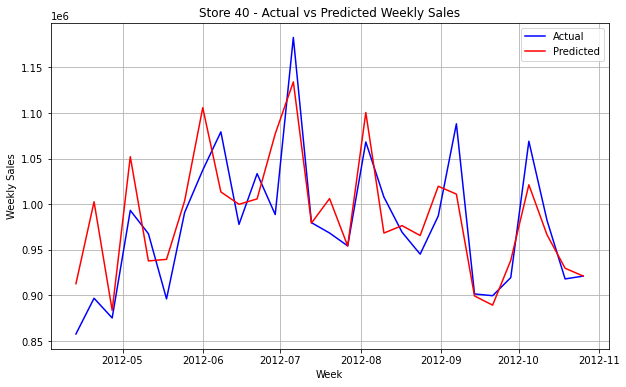

Store 40 results:
                Actual     Predicted     Difference
2012-04-13   857811.17  9.129049e+05  -55093.771906
2012-04-20   896979.93  1.002743e+06 -105762.769388
2012-04-27   875372.91  8.837240e+05   -8351.097651
2012-05-04   993311.59  1.052178e+06  -58866.557097
2012-05-11   967729.35  9.378942e+05   29835.101287
2012-05-18   896295.41  9.396469e+05  -43351.515315
2012-05-25   991054.49  1.003793e+06  -12738.251731
2012-06-01  1037464.27  1.105918e+06  -68453.983703
2012-06-08  1079386.88  1.013547e+06   65840.270414
2012-06-15   977950.28  9.999855e+05  -22035.190554
2012-06-22  1033552.18  1.005928e+06   27624.267507
2012-06-29   988764.84  1.077215e+06  -88449.987835
2012-07-06  1182901.56  1.134188e+06   48713.464666
2012-07-13   979848.71  9.794110e+05     437.744002
2012-07-20   968502.38  1.006250e+06  -37747.409255
2012-07-27   954396.85  9.543133e+05      83.584840
2012-08-03  1068346.76  1.100594e+06  -32247.549832
2012-08-10  1007906.43  9.684768e+05   39429.6

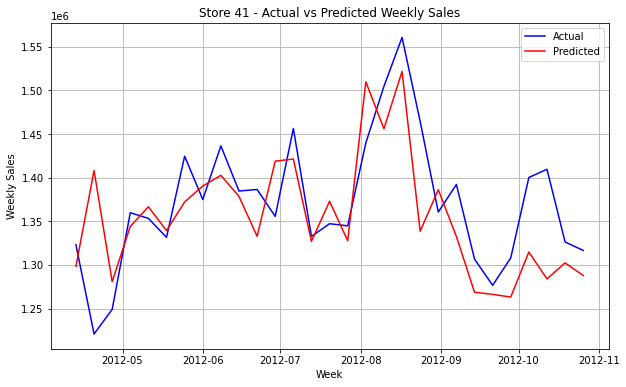

Store 41 results:
                Actual     Predicted     Difference
2012-04-13  1323004.73  1.298327e+06   24677.732149
2012-04-20  1220815.33  1.408164e+06 -187348.345999
2012-04-27  1248950.65  1.280725e+06  -31774.382224
2012-05-04  1359770.73  1.344139e+06   15631.465046
2012-05-11  1353285.10  1.366516e+06  -13230.848887
2012-05-18  1331514.44  1.339260e+06   -7745.873744
2012-05-25  1424500.47  1.372084e+06   52416.635424
2012-06-01  1374891.36  1.390286e+06  -15394.715652
2012-06-08  1436383.84  1.402590e+06   33794.231085
2012-06-15  1384584.59  1.378435e+06    6149.480928
2012-06-22  1386407.17  1.332771e+06   53636.183828
2012-06-29  1355600.01  1.418844e+06  -63244.278819
2012-07-06  1456300.89  1.421302e+06   34998.559014
2012-07-13  1332594.07  1.326909e+06    5685.108533
2012-07-20  1347175.93  1.372901e+06  -25725.225680
2012-07-27  1344723.97  1.327626e+06   17098.250751
2012-08-03  1439607.35  1.509765e+06  -70158.125613
2012-08-10  1504545.94  1.456003e+06   48543.0

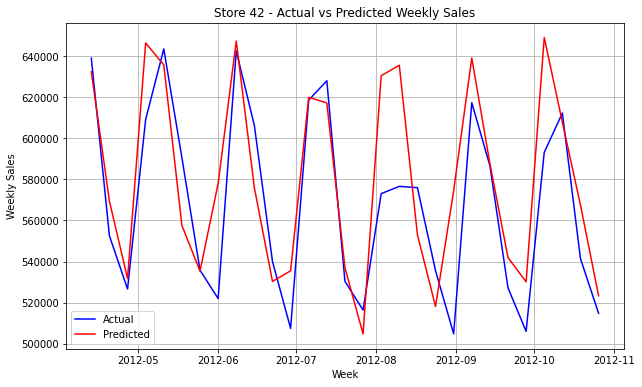

Store 42 results:
               Actual      Predicted    Difference
2012-04-13  639123.45  632462.393562   6661.056438
2012-04-20  552529.23  569366.069168 -16836.839168
2012-04-27  526625.49  531742.876861  -5117.386861
2012-05-04  609274.89  646510.905916 -37236.015916
2012-05-11  643603.69  635830.552712   7773.137288
2012-05-18  590636.38  557630.319868  33006.060132
2012-05-25  535764.58  535314.066235    450.513765
2012-06-01  521953.78  578049.142744 -56095.362744
2012-06-08  642671.48  647448.367950  -4776.887950
2012-06-15  606309.13  575971.588601  30337.541399
2012-06-22  540031.29  530308.065797   9723.224203
2012-06-29  507403.77  535463.137475 -28059.367475
2012-07-06  618702.09  620064.442417  -1362.352417
2012-07-13  628099.08  617257.083664  10841.996336
2012-07-20  530318.39  536949.941942  -6631.551942
2012-07-27  516352.21  504689.015741  11663.194259
2012-08-03  573084.71  630595.449843 -57510.739843
2012-08-10  576620.31  635662.394392 -59042.084392
2012-08-17  5

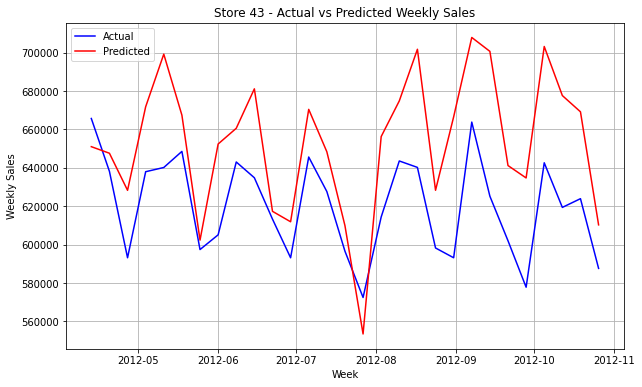

Store 43 results:
               Actual      Predicted    Difference
2012-04-13  665687.92  651010.880202  14677.039798
2012-04-20  638144.98  647585.048127  -9440.068127
2012-04-27  593138.59  628263.374075 -35124.784075
2012-05-04  637964.20  671800.623363 -33836.423363
2012-05-11  640159.04  699210.200347 -59051.160347
2012-05-18  648541.81  667430.810231 -18889.000231
2012-05-25  597406.39  602328.305097  -4921.915097
2012-06-01  605078.62  652394.902300 -47316.282300
2012-06-08  643032.51  660583.543372 -17551.033372
2012-06-15  634815.10  681138.192396 -46323.092396
2012-06-22  613270.79  617325.791439  -4055.001439
2012-06-29  593128.13  611884.100467 -18755.970467
2012-07-06  645618.59  670442.063933 -24823.473933
2012-07-13  627634.04  648362.004123 -20727.964123
2012-07-20  596554.05  609875.433346 -13321.383346
2012-07-27  572447.52  553431.693802  19015.826198
2012-08-03  614378.94  656269.923282 -41890.983282
2012-08-10  643558.78  674861.179212 -31302.399212
2012-08-17  6

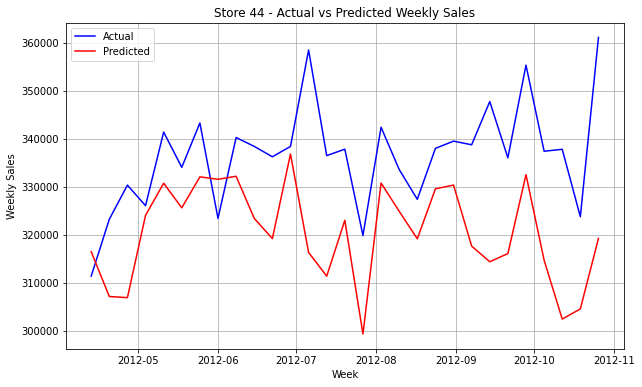

Store 44 results:
               Actual      Predicted    Difference
2012-04-13  311390.22  316487.032525  -5096.812525
2012-04-20  323233.80  307161.125920  16072.674080
2012-04-27  330338.36  306922.473122  23415.886878
2012-05-04  326053.28  324044.972697   2008.307303
2012-05-11  341381.08  330736.972861  10644.107139
2012-05-18  334042.43  325612.358492   8430.071508
2012-05-25  343268.29  332058.610853  11209.679147
2012-06-01  323410.94  331550.448428  -8139.508428
2012-06-08  340238.38  332183.271002   8055.108998
2012-06-15  338400.82  323416.580400  14984.239600
2012-06-22  336241.00  319209.444593  17031.555407
2012-06-29  338386.08  336812.208267   1573.871733
2012-07-06  358461.58  316326.342953  42135.237047
2012-07-13  336479.49  311391.697423  25087.792577
2012-07-20  337819.16  323019.319606  14799.840394
2012-07-27  319855.26  299361.613438  20493.646562
2012-08-03  342385.38  330776.412286  11608.967714
2012-08-10  333594.81  324893.646396   8701.163604
2012-08-17  3

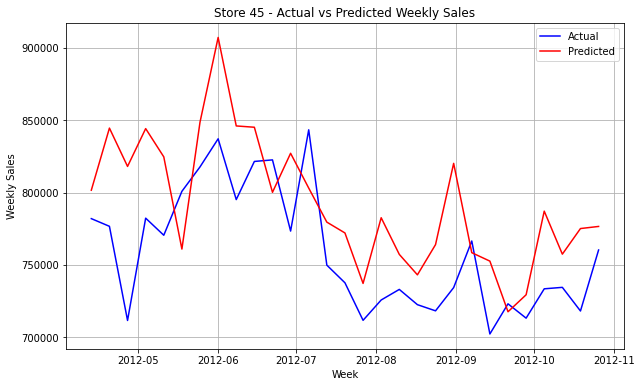

Store 45 results:
               Actual      Predicted     Difference
2012-04-13  781970.60  801618.828637  -19648.228637
2012-04-20  776661.74  844552.572176  -67890.832176
2012-04-27  711571.88  818059.018542 -106487.138542
2012-05-04  782300.68  844202.344874  -61901.664874
2012-05-11  770487.37  824667.370147  -54180.000147
2012-05-18  800842.28  760926.303198   39915.976802
2012-05-25  817741.17  848677.029672  -30935.859672
2012-06-01  837144.63  907199.760384  -70055.130384
2012-06-08  795133.00  846044.132234  -50911.132234
2012-06-15  821498.18  845138.760368  -23640.580368
2012-06-22  822569.16  800159.664908   22409.495092
2012-06-29  773367.71  827135.438311  -53767.728311
2012-07-06  843361.10  803091.052033   40270.047967
2012-07-13  749817.08  779552.182250  -29735.102250
2012-07-20  737613.65  772061.380579  -34447.730579
2012-07-27  711671.58  737179.072511  -25507.492511
2012-08-03  725729.51  782584.175496  -56854.665496
2012-08-10  733037.32  757245.672407  -24208.3

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Function to forecast and calculate differences for a single store's data
def train_test_forecast_model(data, test_size=0.2, forecast_period=12):
    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52)
    fit_model = model.fit()
    forecast = fit_model.forecast(steps=len(test))  # Adjust forecast length to match test data length

    difference = test['Weekly_Sales'] - forecast
    results_df = pd.DataFrame({
        'Actual': test['Weekly_Sales'],
        'Predicted': forecast,
        'Difference': difference
    })
    return results_df

# Function to apply the forecasting to all stores
def forecast_all_stores(df, num_stores=45):
    all_results = []
    for store in range(1, num_stores + 1):
        store_data = df[df['Store'] == store]
        store_data_weekly_sales = pd.DataFrame(store_data['Weekly_Sales'])
        
        results_df = train_test_forecast_model(store_data_weekly_sales)
        all_results.append({
            'Store': store,
            'Results': results_df
        })
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
        plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red')
        plt.title(f'Store {store} - Actual vs Predicted Weekly Sales')
        plt.xlabel('Week')
        plt.ylabel('Weekly Sales')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Store {store} results:")
        print(results_df)

    return all_results

# Example usage with your dataset
forecast_results = forecast_all_stores(df)

# forecast_results will contain the results dataframe for each store
